# Сборный проект 1: исследование компьютерных игр

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.


В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [1]:
try:
    import missingno as msno
except:
    !pip install missingno
    import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from pandas.api.types import is_numeric_dtype

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore", 'This pattern has match groups')

## Изучение общей информации

Получим данные из файла и посмотрим основную информацию:

In [3]:
df_games = pd.read_csv('/datasets/games.csv')
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Приведем названия колонок к нижнему регистру

In [4]:
df_games.columns = df_games.columns.str.lower()

In [5]:
df_games.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.00,Platform,11.28,9.14,6.50,2.88,89.00,8.5,E
7,Wii Play,Wii,2006.00,Misc,13.96,9.18,2.93,2.84,58.00,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.4,E
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Создадим словарь информации о параметрах данных:

In [6]:
title_dict = {
    'name' : 'Название игры',
    'platform': 'Платформа',
    'year_of_release': 'Год выпуска',
    'genre': 'Жанр игры',
    'na_sales': 'Продажи в Северной Америке (млн.)',
    'eu_sales': 'Продажи в Европе (млн.)',
    'jp_sales': 'Продажи в Японии (млн.)',
    'other_sales': 'Продажи в других странах (млн.)',
    'critic_score': 'Оценка критиков',
    'user_score': 'Оценка пользователей',
    'rating': 'Рейтинг от организации ESRB'
}

Построим общую гистограмму:

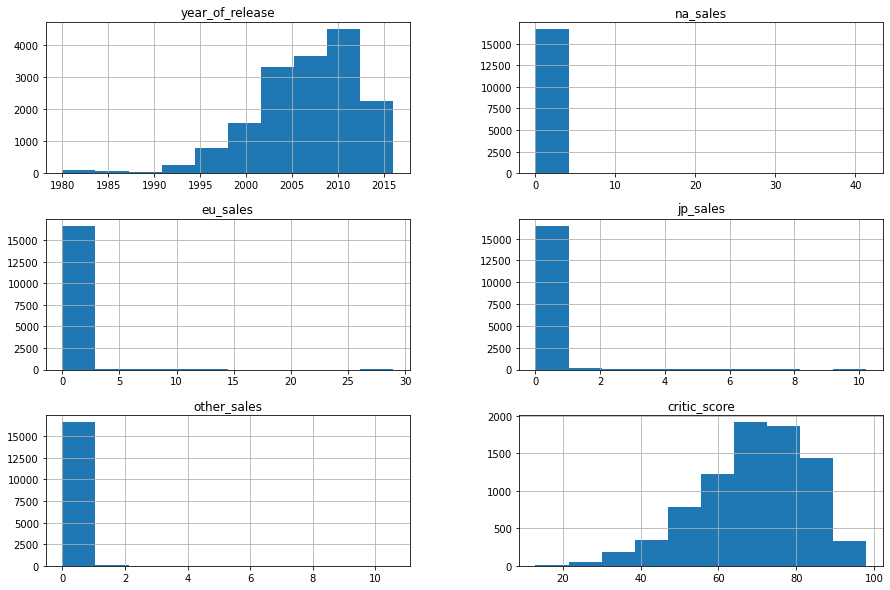

In [7]:
df_games.hist(figsize=(15, 10))
plt.show()

Оценим пропущенные значения в данных:

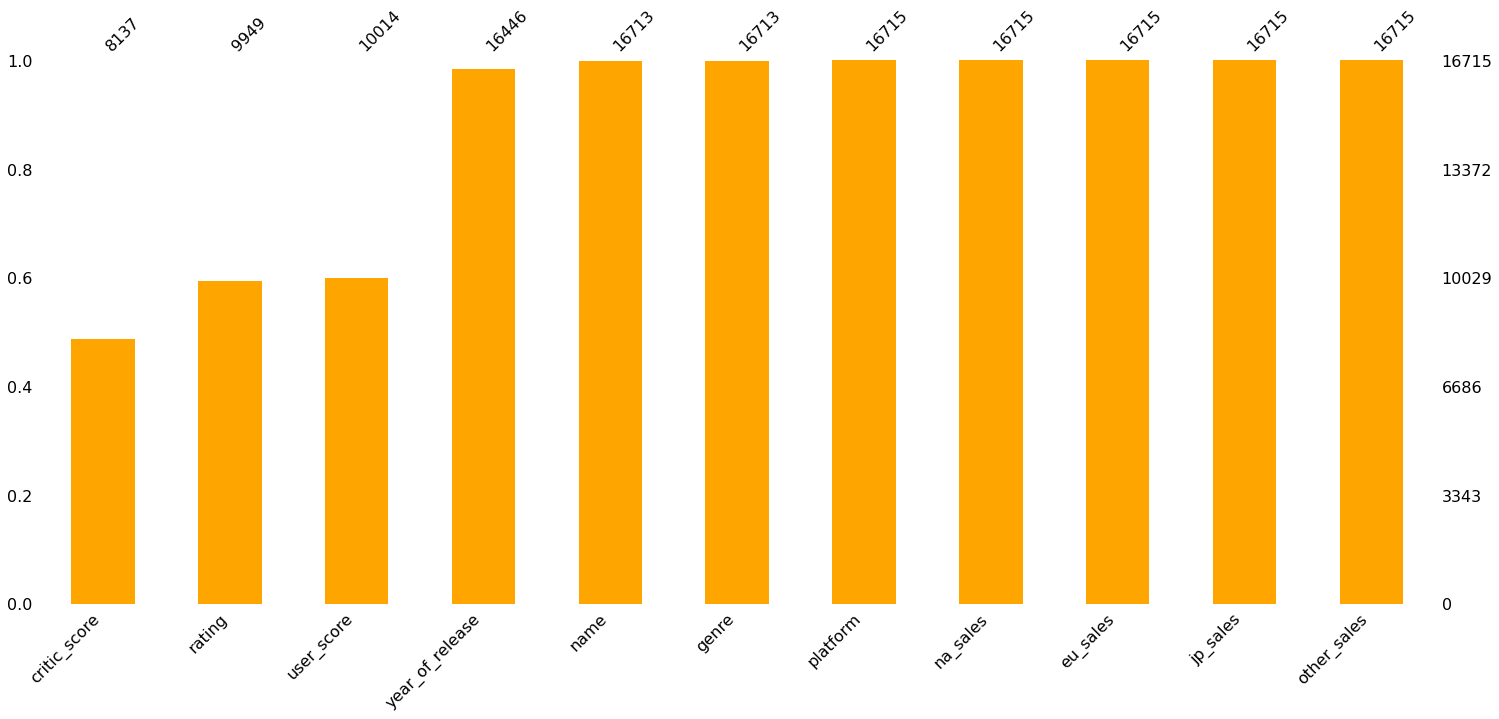

In [8]:
msno.bar(df_games, sort="ascending", color='orange');

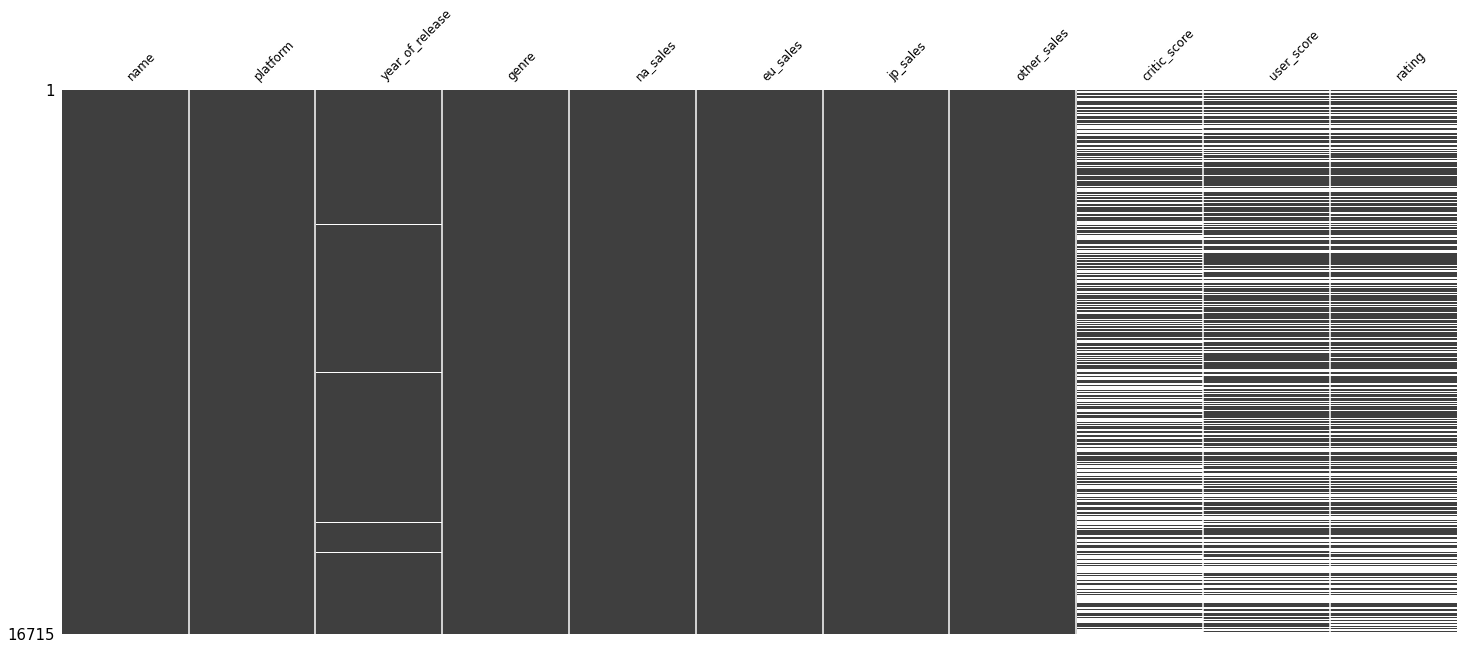

In [9]:
msno.matrix(df_games, fontsize=12, sparkline=False);

**Вывод: первоначальный взгляд на данные**
- Всего **16715** строк.
- Пропущенные значения есть в столбцах 
    - в единичных случаях в `name`, `genre`, `year_of_release`
    - в большом количестве в `critic_score`, `user_score`, `rating`
- По гистограммам можно предположить аномальные значения в столбцах продаж
- По графику пропусков можно сделать вывод, что в основном оценки критиков и рейтинг либо полностью указаны, либо пропущены

## Предобработка данных

**Используемые функции**

In [10]:
def base_check(data: pd.DataFrame,
               name_column: str,
               is_bar: bool = False,
               hist_bins: int = 0,
               ignore_zero_value: bool = False,
               set_title: str = '',
               y_label: str = '',
               x_label: str = '',
               show_info: bool = True,
               **kwargs) -> None:
    
    if set_title:
        titl = set_title
    else:
        titl = f'Количество выпущенных игр по: {title_dict.get(name_column,"")}'
    
    if not x_label:
        x_label = f'{title_dict.get(name_column,"")} ({name_column})'
        
    if not y_label:
        y_label = 'Количество игр'
        
    if any(data[name_column].isna()):
        print(f"Количество пропущенных значений {data[name_column].isna().sum()}")
        print(f"Процент пропущенных значений {data[name_column].isna().mean():.2%}")

    if  is_numeric_dtype(data[name_column]):
        if ignore_zero_value:
            print(f"Количество нулевых значений {(data[name_column] == 0).sum()}")
            print(f"Процент нулевых значений {(data[name_column] == 0).mean():.2%}")
            data = data[data[name_column] != 0]

        describ = data[name_column].agg(['min','median','max'])
        
        if is_bar:
            data[name_column].value_counts().sort_index().plot.bar(xlabel=x_label,
                                                                   ylabel=y_label,
                                                                   **kwargs)
        else:
            if hist_bins == 0:
                hist_bins = int(describ['max'] - describ['min'] + 1)
            data[name_column].hist(bins=hist_bins,
                                   **kwargs)
            plt.xlabel(x_label)
            plt.ylabel(y_label)
        plt.title(titl)
        plt.show()
        if show_info:
            print(describ)
    else:
        data[name_column].value_counts().plot(kind='barh',
                                              color=list('gcybmr'),
                                              title=titl,
                                              xlabel=x_label,
                                              **kwargs).invert_yaxis()
        plt.show()


### Имя игры `name`

Проверим строки с пропущенными значениями

In [11]:
df_games[df_games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.00,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.00,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Строки содержат много пропущенных значений, нет возможности восстановить данные, удалим строки:

In [12]:
df_games = df_games[df_games['name'].notna()]

Для надежности уберем пробельные символы в начале и конце названия и оценим, какие данные встречаются в столбце:

In [13]:
df_games['name'] = df_games['name'].str.strip()
df_games['name'].head(20)

0                                       Wii Sports
1                                Super Mario Bros.
2                                   Mario Kart Wii
3                                Wii Sports Resort
4                         Pokemon Red/Pokemon Blue
5                                           Tetris
6                            New Super Mario Bros.
7                                         Wii Play
8                        New Super Mario Bros. Wii
9                                        Duck Hunt
10                                      Nintendogs
11                                   Mario Kart DS
12                     Pokemon Gold/Pokemon Silver
13                                         Wii Fit
14                              Kinect Adventures!
15                                    Wii Fit Plus
16                              Grand Theft Auto V
17                   Grand Theft Auto: San Andreas
18                               Super Mario World
19    Brain Age: Train Your Bra

Предварительно можно выделить проблемы, которые влияют на неявные дубликаты:
- наличие римских цифр
- наличие названия платформ
- знаки препинания

**Римские цифры**


Посмотрим, какие римские цифры встречаются в названиях, будем учитывать их только в конце строки

In [14]:
roman_pattern = r' M{0,3}(CM|CD|D?C{0,3})?(XC|XL|L?X{0,3})?(IX|IV|V?I{0,3})?$'
df_games[df_games['name'].str.contains(roman_pattern)]['name'].str.split().str[-1].unique()

array(['V', 'II', 'III', 'IV', 'VII', 'X', 'VIII', 'XII', 'XIII', 'IX',
       'DX', 'CD', 'M', 'MX', 'XIX', 'VI', 'XI', 'XL', 'D', 'L', 'XIV',
       'XXX', 'XX', 'CCC'], dtype=object)

Сделаем допущение, что все получившиеся данные именно римские цифры, а не особенности названия игры.


Вариантов мало, можно провести замену по словарю:

In [15]:
roman_dict = {
    'VIII' : '8',
    'XIII' : '13',

    'CCC' : '300',
    'XXX' : '30',
    'XII' : '12',
    'III' : '3',
    'VII' : '7',
    'XIX' : '19',
    'XIV' : '14',

    'XX' : '20',
    'IV' : '4',
    'VI' : '6',
    'II' : '2',
    'IX' : '9',
    'XI' : '11',
    'DX' : '510',
    'CD' : '400',
    'MX' : '1010',
    'XL' : '40',

    'M' : '1000',
    'D' : '500',
    'X' : '10',
    'L' : '50',
    'V' : '5',
    'I' : '1'
}

In [16]:
for key, value in roman_dict.items():
    df_games['name'] = df_games['name'].str.replace(rf' {key}$', f' {value}', regex=True)

Проверим, что римских цифр не осталось:

In [17]:
df_games['name'].str.contains(roman_pattern).sum()

0

**Знаки препинания**

Предположим, что в скобках указываются примечания. Проверим, есть ли такие строки в данных и оценим их.

In [18]:
df_games[df_games['name'].str.contains('\(')].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
87,Star Wars Battlefront (2015),PS4,2015.00,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN
342,Star Wars Battlefront (2015),XOne,2015.00,Shooter,2.04,1.28,0.02,0.32,NaN,NaN,NaN
416,Gran Turismo (PSP),PSP,2009.00,Racing,0.50,1.58,0.31,0.87,NaN,NaN,NaN
603,Ghostbusters: The Video Game (DS Version),X360,2009.00,Action,1.04,1.22,0.03,0.27,NaN,NaN,NaN
639,Need for Speed (2015),PS4,2015.00,Racing,0.50,1.50,0.05,0.37,NaN,NaN,NaN
646,Tomb Raider (2013),PS3,2013.00,Action,0.60,1.26,0.08,0.48,NaN,NaN,NaN
788,Project Gotham Racing (JP weekly sales),XB,2002.00,Action,1.54,0.44,0.04,0.07,NaN,NaN,NaN
828,Ghostbusters: The Video Game (DS Version),PS3,2010.00,Action,0.60,0.96,0.13,0.36,NaN,NaN,NaN
910,Tomb Raider (2013),X360,2013.00,Action,0.86,0.84,0.01,0.17,NaN,NaN,NaN
920,Medal of Honor: European Assault (All Region s...,PS2,2005.00,Shooter,0.89,0.69,0.09,0.21,NaN,NaN,NaN


Похоже, что предположение верно. В скобках указаны дата выхода игры, платформа, информация о распродаже. Перенесем эту информацию в отдельный столбец и удалим из названия

In [19]:
pattern = '(\(.*?\))'
df_games['name_notes'] = df_games['name'].str.extract(pattern)
df_games['name_notes'] = df_games['name_notes'].str[1:-1]
df_games['name'] = df_games['name'].str.replace(pattern, '', regex=True)
df_games.query('name_notes.notna()').head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_notes
87,Star Wars Battlefront,PS4,2015.00,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,2015
342,Star Wars Battlefront,XOne,2015.00,Shooter,2.04,1.28,0.02,0.32,NaN,NaN,NaN,2015
416,Gran Turismo,PSP,2009.00,Racing,0.50,1.58,0.31,0.87,NaN,NaN,NaN,PSP
603,Ghostbusters: The Video Game,X360,2009.00,Action,1.04,1.22,0.03,0.27,NaN,NaN,NaN,DS Version
639,Need for Speed,PS4,2015.00,Racing,0.50,1.50,0.05,0.37,NaN,NaN,NaN,2015
646,Tomb Raider,PS3,2013.00,Action,0.60,1.26,0.08,0.48,NaN,NaN,NaN,2013
788,Project Gotham Racing,XB,2002.00,Action,1.54,0.44,0.04,0.07,NaN,NaN,NaN,JP weekly sales
828,Ghostbusters: The Video Game,PS3,2010.00,Action,0.60,0.96,0.13,0.36,NaN,NaN,NaN,DS Version
910,Tomb Raider,X360,2013.00,Action,0.86,0.84,0.01,0.17,NaN,NaN,NaN,2013
920,Medal of Honor: European Assault,PS2,2005.00,Shooter,0.89,0.69,0.09,0.21,NaN,NaN,NaN,All Region sales


Обработаем имена игр:
- в нижнем регистре
- оставим в названии буквы алфавита, цифры, `-` и `'`
- уберем лишние пробелы

In [20]:
df_games['name'] = df_games['name'].str.replace(r'[^a-zA-Z0-9-\' ]', ' ', regex=True).str.lower()
df_games['name'] = df_games['name'].str.replace(r'\s{2,}', ' ', regex=True).str.strip()
df_games.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_notes
0,wii sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E,NaN
1,super mario bros,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,NaN
2,mario kart wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E,NaN
3,wii sports resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E,NaN
4,pokemon red pokemon blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,NaN


Оставшиеся названия платформ в играх, например "mario kart wii" - будем считать, что во всех случаях это особенности названия игры, а не ошибка заполнения или дублирование информации.


Проверим дупликаты по очищенному имени игры, платформе и году релиза:

In [21]:
df_games[df_games.duplicated(subset=['platform','name','year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_notes
1324,tony hawk's american wasteland,PS2,2005.00,Sports,1.38,0.05,0.00,0.02,NaN,NaN,NaN,Weekly american sales
1350,nba live 06,PS2,2005.00,Sports,1.35,0.05,0.00,0.02,NaN,NaN,NaN,Weekly american sales
1467,ratchet clank up your arsenal,PS2,2004.00,Platform,1.27,0.05,0.00,0.02,NaN,NaN,NaN,Weekly american sales
1747,yu-gi-oh the sacred cards,GBA,2002.00,Role-Playing,0.84,0.27,0.00,0.05,NaN,NaN,NaN,American and Others sales
3219,ghostbusters the video game,X360,2009.00,Action,0.43,0.14,0.00,0.06,79.00,8.5,T,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16426,rondo of swords,DS,2007.00,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN,jp sales
16506,the godfather,X360,2006.00,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,JP sales
16616,national geographic panda,DS,2008.00,Simulation,0.00,0.00,0.01,0.00,NaN,NaN,NaN,JP sales
16656,imagine figure skater,DS,2007.00,Sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN,JP sales


Появилось 112 "частичных" дублей. <br>
Можно оценить, что в столбце заметок почти везде указана распродажа. Пока оставим эти данные, как есть, т.к. можно предположить влияние факта распродажи на количество проданных копий.

### Платформы `platform`

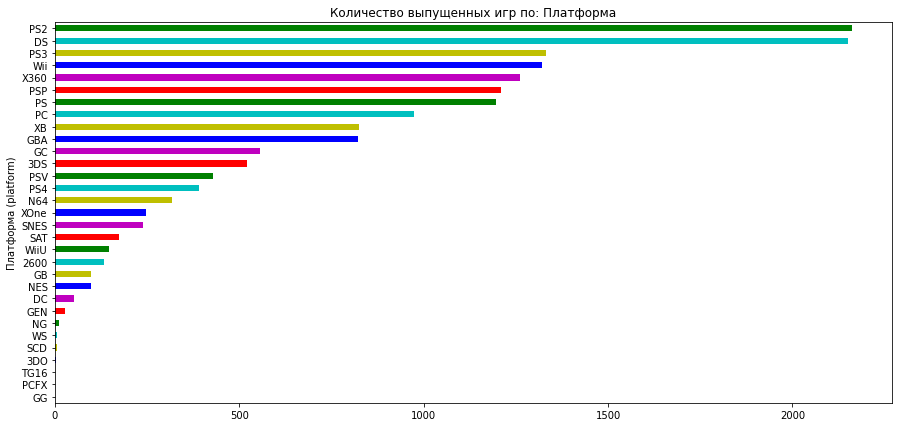

In [22]:
base_check(df_games, 'platform', figsize=(15,7))

Пропущенных значений нет, названия платформ не повторяются.


Для удобства можно перевести названия платформ в нижний регистр.

In [23]:
df_games['platform'] = df_games['platform'].str.lower()

Для игровых платформ аномальные значения в данных могут быть связаны с датой релиза платформы. Информации про даты выхода платформы в данных нет, но можно построить общую гистограмму для каждой платформы по годам и оценить "выбросы" слева от основной массы.

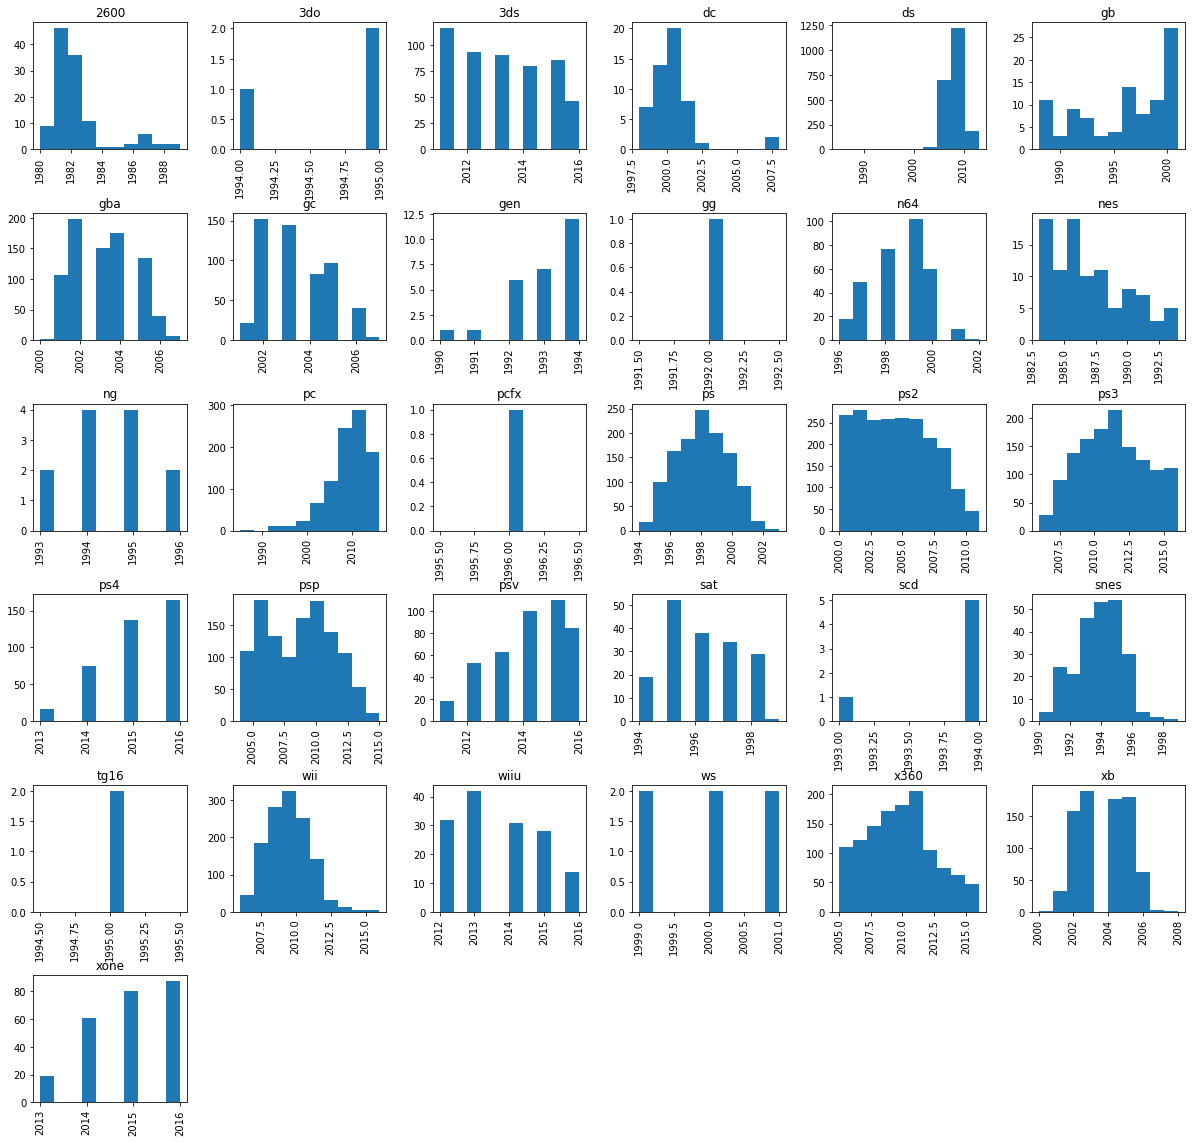

In [24]:
df_games['year_of_release'].hist(by=df_games['platform'], figsize=(20,20));

Почти все данные расположены компактно, кроме платформы `DS` - Nintendo DS, релиз платформы в **2004** году. 

In [25]:
df_games.query('platform == "ds" and year_of_release < 2004')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_notes
15957,strongest tokyo university shogi ds,ds,1985.00,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN,NaN


Дата выпуска игры сильно отличается от даты выхода платформы. Удалим эту запись.

In [26]:
df_games = df_games.query('not (platform == "ds" and year_of_release < 2004)')

### Год релиза `year_of_release`

Количество пропущенных значений 269
Процент пропущенных значений 1.61%


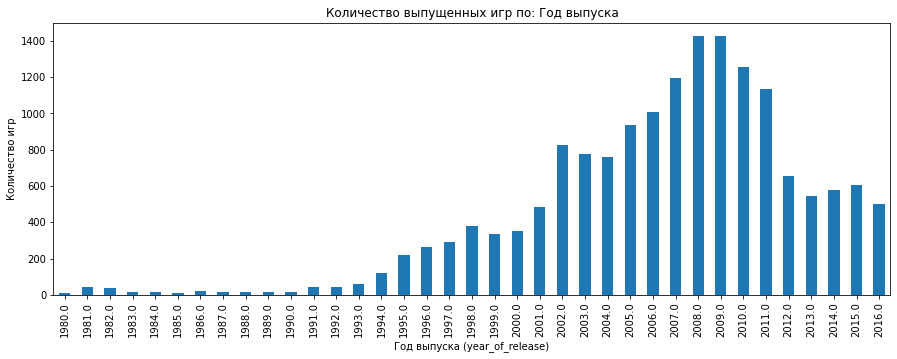

min      1980.00
median   2007.00
max      2016.00
Name: year_of_release, dtype: float64


In [27]:
base_check(df_games, 'year_of_release', is_bar=True, figsize=(15,5))

Год выпуска игры важен для прогнозирования и данные, где год выпуска не указан, придется удалить, тем более объем таких данных небольшой.


Попробуем заполнить пропуски по информации из имени игры. Заполнять на основе названия игры не имеет смысла, т.к. одна и та же игра на разных платформах могла выходить с разницей в несколько лет.

- информация из заметок

In [28]:
df_games.query('year_of_release.isna() and name_notes.notna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_notes
5294,dragon ball z budokai tenkaichi 2,wii,NaN,Action,0.15,0.05,0.14,0.01,NaN,NaN,NaN,JP sales
5336,tomb raider,pc,NaN,Action,0.06,0.25,0.00,0.04,86.00,8.5,M,2013
6255,the legend of zelda the minish cap,gba,NaN,Action,0.00,0.00,0.27,0.01,NaN,NaN,NaN,weekly JP sales
10764,luminous arc 2,ds,NaN,Role-Playing,0.00,0.00,0.10,0.00,NaN,NaN,NaN,JP sales
12568,prinny can i really be the hero,psp,NaN,Action,0.06,0.00,0.00,0.00,NaN,NaN,NaN,US sales
15557,yu-gi-oh 5d's wheelie breakers,wii,NaN,Racing,0.00,0.00,0.02,0.00,NaN,NaN,NaN,JP sales


Есть одно значение, для которого нет информации о годе релиза, но эта информация содержится в `name_notes`.
Заполним его

In [29]:
df_games.loc[(df_games['name_notes'].fillna('').str.isdigit()) & 
             (df_games['year_of_release'].isna()), 'year_of_release'] = df_games['name_notes']

- информация из названия игры (если в конце названия указаны 4 цифры)

In [30]:
df_games[df_games['name'].str.contains(r'\d{4}$')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_notes
183,madden nfl 2004,ps2,NaN,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E,NaN
206,warzone 2100,ps,1999.00,Strategy,2.79,1.89,0.00,0.33,NaN,NaN,NaN,NaN
238,madden nfl 2005,ps2,2004.00,Sports,4.18,0.26,0.01,0.08,91.00,7.9,E,NaN
250,winning eleven pro evolution soccer 2007,ps2,2006.00,Sports,0.10,2.39,1.05,0.86,86.00,8.9,E,NaN
283,madden nfl 2003,ps2,2002.00,Sports,3.36,0.21,0.01,0.56,95.00,7.7,E,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16658,driving simulator 2011,pc,2011.00,Racing,0.00,0.01,0.00,0.00,NaN,NaN,NaN,NaN
16676,g1 jockey 4 2008,ps3,2008.00,Sports,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN
16697,bust-a-move 3000,gc,2003.00,Puzzle,0.01,0.00,0.00,0.00,53.00,tbd,E,NaN
16711,lma manager 2007,x360,2006.00,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,NaN


Можно заметить, что для многих игр 4 цифры в конце соответствуют году выхода игры с погрешностью в 1 год.  Для других игр это особенности названия.


Т.к. строки без данных все равно придется удалить - где возможно, заполним пропуски исходя из числа в названии игры, аномальные значения(менее 1980 и более 2016) удалим вместе с пропусками.

In [31]:
df_games.loc[(df_games['name'].str.contains("\d{4}$")) & 
             (df_games['year_of_release'].isna()),'year_of_release'] = df_games['name'].str.split().str[-1]

Удалим все пропущенные значения и переведем в тип int

In [32]:
df_games = df_games[df_games['year_of_release'].notna()]
df_games['year_of_release'] = df_games['year_of_release'].astype('int32')

Оценим полученный результат и наличие аномалий

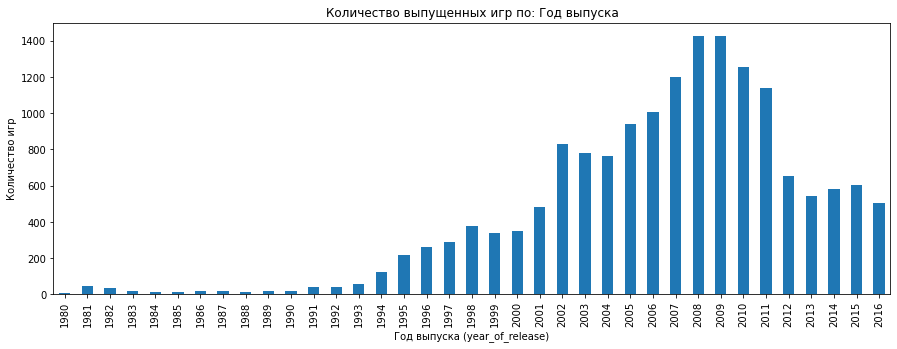

min      1980.00
median   2007.00
max      2016.00
Name: year_of_release, dtype: float64


In [33]:
base_check(df_games, 'year_of_release', is_bar=True, figsize=(15,5))

Пропуски удалены, аномальные значения не появились.

### Оценки `user_score`, `critic_score`

По общей гистограмме данных можно отметить, что не была построена гистограмма по `user_score`, которая должна содержать числовые значения. <br>
Так же тип данных object, когда должен быть float <br>
Проверим, какие данные содержит этот параметр.

In [34]:
df_games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Найдена оценка 'tbd' - To Be Determined (будет определено). По сути, оценка для игры отсутствует и можно сделать замену на NaN и перевести столбец в тип `float`

In [35]:
df_games.loc[df_games['user_score'] == 'tbd', 'user_score'] = float('NaN')
df_games['user_score'] = df_games['user_score'].astype('float')

Количество пропущенных значений 8986
Процент пропущенных значений 54.60%


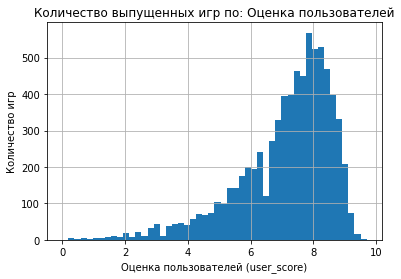

min      0.00
median   7.50
max      9.70
Name: user_score, dtype: float64


In [36]:
base_check(df_games, 'user_score', hist_bins=50)

В данных больше половины пропущенных значений. Попробуем оценить, откуда они взялись.

Предположим, что оценка не ставилась для игр, выпущенных раньше определенного года:

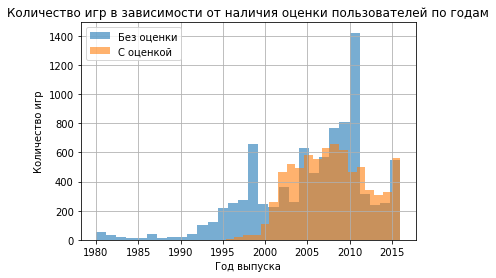

In [37]:
df_games.query('user_score.isna()')['year_of_release'].hist(alpha=0.6, bins=30)
df_games.query('user_score.notna()')['year_of_release'].hist(alpha=0.6, bins=30);
plt.title('Количество игр в зависимости от наличия оценки пользователей по годам')
plt.legend(['Без оценки','С оценкой'])
plt.xlabel(title_dict.get('year_of_release'))
plt.ylabel('Количество игр');

По графикам заметно, что до 2000 оценков игр было совсем мало, но в остальном предположение про зависимость года выхода игры и наличие оценки не подтвердилось.

In [38]:
df_games.groupby('platform')['user_score'].median().head(10)

platform
2600    NaN
3do     NaN
3ds    7.10
dc     8.80
ds     7.40
gb      NaN
gba    8.00
gc     8.00
gen     NaN
gg      NaN
Name: user_score, dtype: float64

Заполнить пропуски на данном этапе невозможно. <br>
Общее медианное значение некорректно, как видно, у игр для некоторых платформ оценки вообще отсутствуют, у некоторых  медианные оценки (dc = **8.8**) отличаются от общего медианного (**7.5**). Так же возможно влияние и других факторов, такие как жанр, год выпуска, продажи и прочее.


**Оставим пропуски**



&nbsp;




**Оценки критиков**

Количество пропущенных значений 8464
Процент пропущенных значений 51.42%


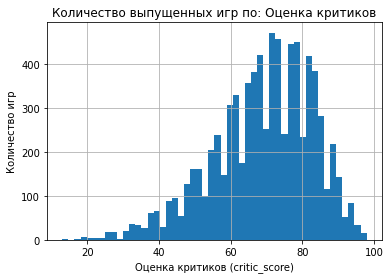

min      13.00
median   71.00
max      98.00
Name: critic_score, dtype: float64


In [39]:
base_check(df_games, 'critic_score', hist_bins=50)

Аналогично оценкам пользователя, **оставляем пропущенные значения** в оценках критиков.

### Рейтинг игры `rating`

Количество пропущенных значений 6680
Процент пропущенных значений 40.59%


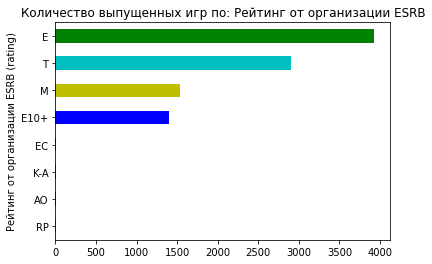

In [40]:
base_check(df_games, 'rating')

Расшифровка сокращений:
- `E` (Everyone) — Для всех
- `T` (Teen) — Подросткам
- `M` (Mature) — Для взрослых
- `E10+` (Everyone 10 and older) — Для всех от 10 лет и старше
- `EC` (Early childhood) — Для детей младшего возраста
- `K-A` (Kids to Adults) — Для детей и взрослых 
- `RP` (Rating Pending) — Рейтинг ожидается
- `AO` (Adults Only 18+) — Только для взрослых

В данном случае `RP` аналогично пропущенному значению, можно произвести замену.

In [41]:
df_games.loc[df_games['rating'] == 'RP', 'rating'] = float('NaN')

Рейтинг `K-A` устаревший, в 1998 году был переименован в `E`. Сделаем замену

In [42]:
df_games.loc[df_games['rating'] == 'K-A', 'rating'] = 'E'

В рейтинге так же много пропусков, заменить которые не получится.
**Оставляем пропуски**


### Продажи `na_sales`, `eu_sales`, `jp_sales`, `other_sales`

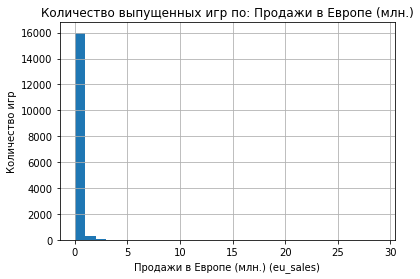

min       0.00
median    0.02
max      28.96
Name: eu_sales, dtype: float64


In [43]:
base_check(df_games, 'eu_sales')

Минимальное значение равно нулю. <br> Т.к. продажи даны в млн копий попробуем оценить, что означает ноль в данном параметре.


Посмотрим, сколько значений строго равно нулю, какое минимальное значение за вычетом нуля. И рассмортим график в области большинства значений.

Количество нулевых значений 5768
Процент нулевых значений 35.04%


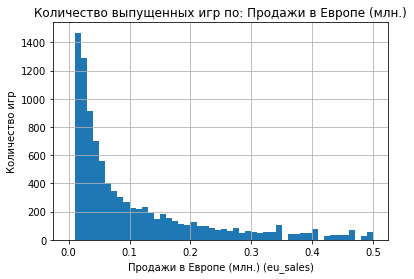

min       0.01
median    0.07
max      28.96
Name: eu_sales, dtype: float64


In [44]:
base_check(df_games, 'eu_sales', ignore_zero_value=True, hist_bins=50, range=(0,0.5))

Минимальное значение без учета нуля равно **0.01** - это может означать, что ноль в данных не обязательно означает, что продаж игры в регионе не было, он может говорить, что количество продаж меньше 0.01млн. Так же возможно, что это стандартное значение в том случае, если не было заполнено.


Так же оценим данные, которые значительно выбиваются

In [45]:
df_games.query('eu_sales > 10')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,name_notes
0,wii sports,wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,NaN
2,mario kart wii,wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,NaN
3,wii sports resort,wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,NaN
10,nintendogs,ds,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,NaN


Самые высокие продажи у игры **Wii Sports** - это игра, которая выпущена специально для этой приставки и в странах, кроме Японии, была вложена в коробку с самой приставкой. Значит, для данной игры невозможно оценить "прямые" продажи, т.е. сколько людей купило бы игру отдельно<br>
**Пока не будем удалять это значение**, но, возможно, это придется учитывать при дальнейшем анализе


Так же проверим данные для продаж в остальных странах. Общие графики для всего объема значений были построены в самом начале, возьмем "основную" область продаж без учета "нулевых" продаж.

Количество нулевых значений 4451
Процент нулевых значений 27.04%


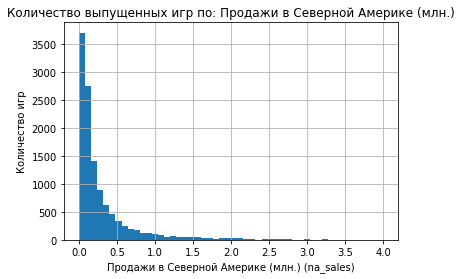

min       0.01
median    0.14
max      41.36
Name: na_sales, dtype: float64


In [46]:
base_check(df_games, 'na_sales', ignore_zero_value=True, hist_bins=50, range=(0,4))

Количество нулевых значений 10313
Процент нулевых значений 62.66%


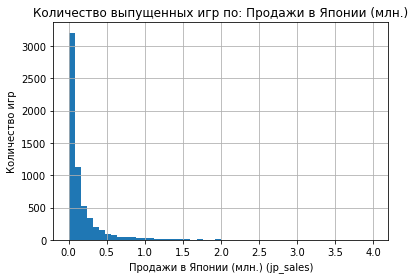

min       0.01
median    0.07
max      10.22
Name: jp_sales, dtype: float64


In [47]:
base_check(df_games, 'jp_sales', ignore_zero_value=True, hist_bins=50, range=(0,4))

Количество нулевых значений 6495
Процент нулевых значений 39.46%


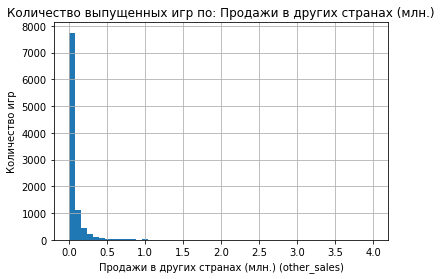

min       0.01
median    0.02
max      10.57
Name: other_sales, dtype: float64


In [48]:
base_check(df_games, 'other_sales', ignore_zero_value=True, hist_bins=50, range=(0,4))

В общем и целом картина такая же. Есть достаточно большой объем игр, чьи продажи менее **0.01** млн. копий, есть выделяющиеся значения.


**Оставляем все значения**

Создадим колонку с общими продажами по всем регионам.

In [49]:
df_games['total_sales'] = df_games[[x for x in df_games.columns if 'sale' in x]].sum(axis=1)
title_dict['total_sales'] = 'Продажи по всем регионам (млн.)'

Оценим, какие данные получились

Количество нулевых значений 2
Процент нулевых значений 0.01%


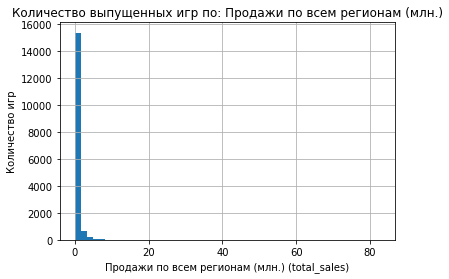

min       0.01
median    0.17
max      82.54
Name: total_sales, dtype: float64


In [50]:
base_check(df_games.query('name != "Wii Sports"'), 'total_sales', ignore_zero_value=True, hist_bins=50)

Можно отметить, что нулевые значения практически изчезли.

Еще раз проверим на явные дубликаты.

In [51]:
df_games.duplicated().sum()

0

### Итог
- рассмотрены и оценены все представленные данные
- для всех имеющихся данных оценены пропущенные значения и произведены замены, удаление данные, либо оставлены без изменения
- обработаны аномальные значения
- изменены типы данных там, где необходимо

## Исследовательский анализ данных

**Используемые функции**


In [52]:
def boxplotting(column_: str,
                data: pd.DataFrame = df_games,
                by_: str = None,
                titl: str = '',
                figsize_: tuple = (15,15),
                vertical: bool = False,
                lim: list = None,
                **kwagrs) -> None:

    data.boxplot(column=column_, 
                 by=by_,
                 vert=vertical,
                 figsize=figsize_,
                 **kwagrs)   
    
    if vertical:
        plt.ylim(lim)
        plt.ylabel(f'{title_dict.get(column_, column_)} ({column_})')
        plt.xlabel(f'{title_dict.get(by_, by_)} ({by_})')
    else:
        plt.xlim(lim)
        plt.xlabel(f'{title_dict.get(column_, column_)} ({column_})')
        plt.ylabel(f'{title_dict.get(by_, by_)} ({by_})')

    plt.suptitle('')
    plt.title(titl if titl else title_dict.get(column_, column_));

### Год выпуска игры `year_of_release`

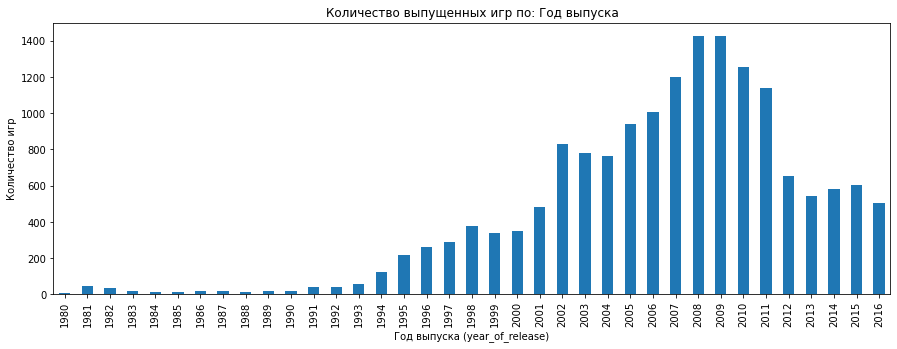

min      1980.00
median   2007.00
max      2016.00
Name: year_of_release, dtype: float64


In [53]:
base_check(df_games,'year_of_release', is_bar=True, figsize=(15,5))

По графику можно выделить несколько этапов развития компьютерных игр:
- **1980-1994** - игры не очень популярны, продаж стабильно мало
- **1995-2001** - рост популярности игр
- **2002-2006** - резкий пик в продажах игр
- **2007-2011** - "золотой век" игр
- **2012-2016** - резкое снижение популярности и "плато" с тенденцией к снижению


На подобную картину мог повлиять ряд факторов, такие как
- доступность компьютера и прочих игровых платформ
- общая популярность игр
- процент "сложных" и "красочных" игр - с развитием технологий разработчики получили возможность делать игры с лучшей графикой, более сложным игровым процессом и т.п.. На разработку таких игр тратится больше времени и финансов => количество игр меньше 

Так же можно оценить количество проданных игр по годам выпуска

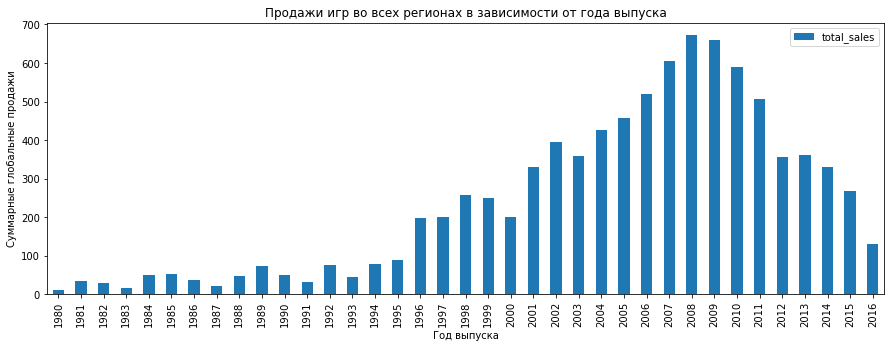

In [54]:
df_games.pivot_table(index='year_of_release', 
                     values='total_sales', 
                     aggfunc=(sum)).plot.bar(title='Продажи игр во всех регионах в зависимости от года выпуска',
                                             xlabel=title_dict.get('year_of_release'),
                                             ylabel='Суммарные глобальные продажи',
                                             figsize=(15,5));

Тут график растет плавнее, но основные периоды вполне совпадают, за исключением резкого спада в 2016 году, что может быть обусловлено неполными данными за 2016 год.


**Предварительно**, для дальнейшего анализа и прогнозирования имеет смысл взять данные текущего "периода" развития - **2012-2016**

### Платформа `platform`

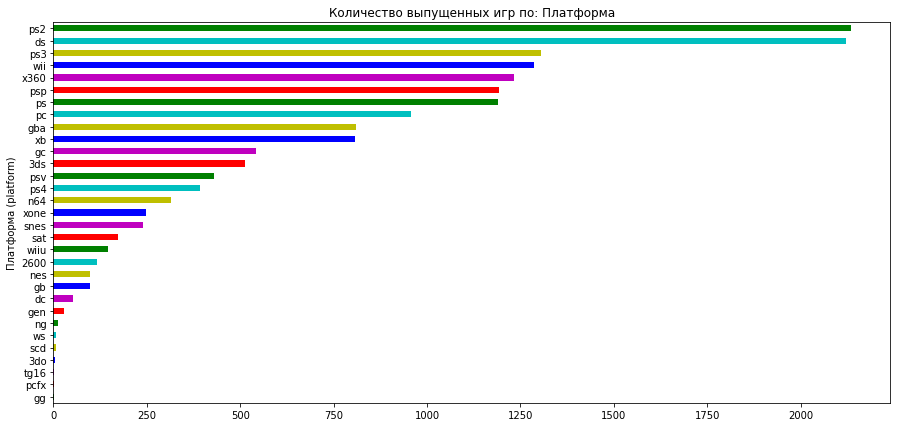

In [55]:
base_check(df_games, 'platform', figsize=(15,7))

Выделим информацию о каждой платформе:

In [56]:
platform_info = df_games.pivot_table(index='platform',
                     values=['year_of_release','total_sales'],
                     aggfunc={'year_of_release' : [lambda x: 1+max(x)-min(x), 'max', 'count', 'min'], 
                              'total_sales':'sum'}
                    )

platform_info.columns = ['total_sales','life_time','count_games','last_year', 'first_year']
platform_info['game_per_year'] = platform_info['count_games'] / platform_info['life_time']
print(platform_info.median())

platform_info.sort_values(by='total_sales', ascending=False).style \
                                                            .highlight_max(color='lightgreen') \
                                                            .background_gradient(subset='life_time')

total_sales      200.04
life_time          7.00
count_games      247.00
last_year       2007.00
first_year      1998.00
game_per_year     29.94
dtype: float64


,total_sales,life_time,count_games,last_year,first_year,game_per_year
platform,,,,,,
ps2,1247.280000,12,2134,2011,2000,177.833333
x360,961.300000,12,1234,2016,2005,102.833333
ps3,931.340000,11,1306,2016,2006,118.727273
wii,891.180000,11,1286,2016,2006,116.909091
ds,802.770000,10,2121,2013,2004,212.100000
ps,727.580000,10,1190,2003,1994,119.000000
ps4,314.140000,4,392,2016,2013,98.000000
gba,312.880000,8,811,2007,2000,101.375000
psp,289.540000,12,1194,2015,2004,99.500000


Возьмем 11 платформ с наибольшим количеством продаж и построим по ним графики

Медианные значения для платформ с большим количеством продаж:
total_sales      727.58
life_time         11.00
count_games     1194.00
last_year       2016.00
first_year      2004.00
game_per_year    102.83
dtype: float64


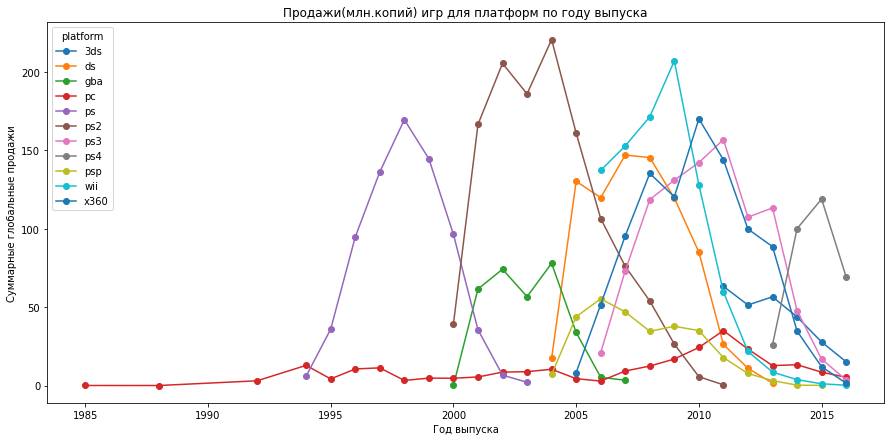

In [57]:
platform_name = platform_info.query('total_sales > 255').index.tolist()
print(f"Медианные значения для платформ с большим количеством продаж:\n\
{platform_info.query('total_sales > 255').median()}")
df_games.query('platform in @platform_name').pivot_table(index='year_of_release', 
                                                         columns='platform', 
                                                         values='total_sales',
                                                         aggfunc='sum').plot.line(figsize=(15,7), 
                                                                                  marker='o')
plt.xlabel(title_dict.get('year_of_release'))
plt.ylabel('Суммарные глобальные продажи')
plt.title('Продажи(млн.копий) игр для платформ по году выпуска');

**По данным для 11 платформ с наибольшими продажами игр** 
можно сделать вывод, что в основном для платформы игры выпускаются в течении **11** лет по **103** игры в год. У многих платформ ярко выраженный "пик" в продажах на 4-6 год. Игры для `pc` выпускаются больше всего, каждый год продажи не большие, но относительно стабильно. 


**По всем данным**
Существуют платформы, для которых было выпущено менее **15** игр и которые просуществовали **1-2** года, например `gg`, `scd`, `pcfx` и т.п. 


Так же есть платформы, которые существуют уже более **10** лет и выпускают игры на момент **2016** года, это `x360`, `wii`, `pc`. 



Для прогноза продаж на **2017** год имеет смысл брать только те платформы, по которым были продажи в **2016** году, т.к. отсутствие продаж говорит о каких-то проблемах с платформой - потеряла популярность, устарела, перестала поддерживаться и пр. и ожидание игр от этих платформ в **2017** году сомнительно.



Выберем актуальные на **2016** год платформы и построим по ним гистограммы

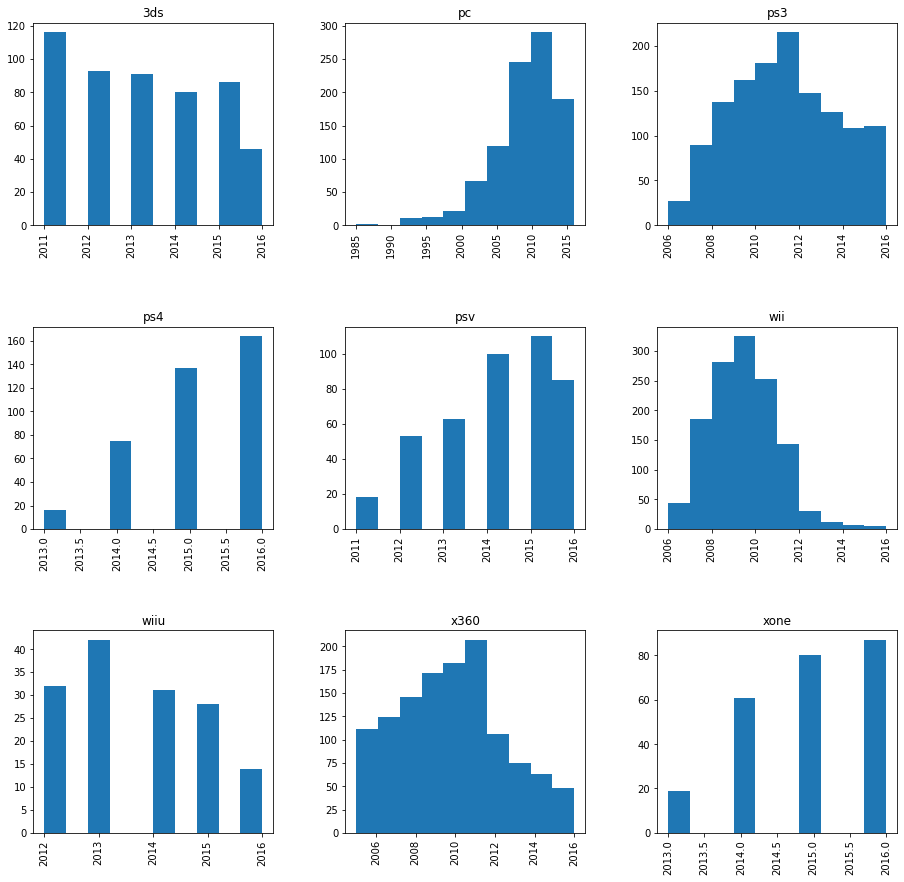

In [58]:
platform_name = platform_info.query('last_year == 2016').index.tolist()
df_games.query('platform in @platform_name')['year_of_release'].hist(by=df_games['platform'], figsize=(15,15));

В прошлом шаге предварительно для исследования был выбран период **2012-2016**.<br>
У некоторых платформ наблюдается значительное снижение популярности в последние годы (`wii`, `x360`), некоторые появились не так давно и наблюдается рост (`xone`, `ps4`).


Для консоли `wii` поддержка была прекращена 20.10.2013, с чем связано значительное падение выпущенных игр.


Для ряда платформ (`ps3`, `x360`) ситуация схожа с общими продажами игр, резкий спад **2012** года. Так же были выпущены приставки следующего поколения (`ps4` и `xone` соответственно), что тоже влияет на общее количество игр. Но эти платформы все еще актуальны.


### Выбор данных для прогнозирования

Таким образом выделим актуальные для прогнозирования данные:
- 2012-2016 год выпуска игры 
    - медианный жизненный цикл для всех платформ 7 лет, а для платформ с наибольшими продажами "пик" находится в районе 5 лет => период в 5 лет вполне достаточный, чтоб оценить потенциально прибыльную платформу
        - если платформы не было в первый год рассматриваемого периода и она появляется позже, можно ожидать что жизненный цикл будет продолжаться минимум пару лет и платформа потенциально прибыльна.
        - для остальных платформ по объему продаж и характеру распределения можно определить на каком этапе находится платформа сейчас 
        - отдельно стоит выделить платформу `pc` - у нее серьезные изменения мощностей происходят внутри платформы без измнения названия, в отличии от приставок. 
    - характерное "плато" для количества выпущенных игр - период развития игровой индустрии
- платформы, которые выпускали игры в 2016 году

In [59]:
df_games_actual = df_games.query('platform in @platform_name and year_of_release > 2011')
df_games_actual = df_games_actual.reset_index(drop=True)
df_games_actual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2683 non-null   object 
 1   platform         2683 non-null   object 
 2   year_of_release  2683 non-null   int32  
 3   genre            2683 non-null   object 
 4   na_sales         2683 non-null   float64
 5   eu_sales         2683 non-null   float64
 6   jp_sales         2683 non-null   float64
 7   other_sales      2683 non-null   float64
 8   critic_score     1311 non-null   float64
 9   user_score       1525 non-null   float64
 10  rating           1590 non-null   object 
 11  name_notes       66 non-null     object 
 12  total_sales      2683 non-null   float64
dtypes: float64(7), int32(1), object(5)
memory usage: 262.1+ KB


### Выбор потенциально прибыльных платформ:


Посмотрим количество игр по платформам для актуальных данных и данные по продажам.

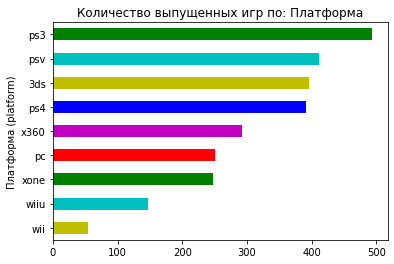

In [60]:
base_check(df_games_actual, 'platform')

In [61]:
platform_info.query('last_year == 2016').style.background_gradient()

,total_sales,life_time,count_games,last_year,first_year,game_per_year
platform,,,,,,
3ds,257.810000,6,512,2016,2011,85.333333
pc,256.110000,32,958,2016,1985,29.937500
ps3,931.340000,11,1306,2016,2006,118.727273
ps4,314.140000,4,392,2016,2013,98.000000
psv,53.810000,6,429,2016,2011,71.500000
wii,891.180000,11,1286,2016,2006,116.909091
wiiu,82.190000,5,147,2016,2012,29.400000
x360,961.300000,12,1234,2016,2005,102.833333
xone,159.320000,4,247,2016,2013,61.750000


In [62]:
platform_info_actual = df_games_actual.pivot_table(index='year_of_release', 
                                                   columns='platform',
                                                   values='total_sales',
                                                   aggfunc='sum')
platform_info_actual.style \
                    .highlight_null(null_color='grey') \
                    .highlight_max(color='lightblue') \
                    .highlight_min(color='pink')

platform,3ds,pc,ps3,ps4,psv,wii,wiiu,x360,xone
year_of_release,,,,,,,,,
2012,51.360000,23.220000,107.360000,nan,16.190000,21.710000,17.560000,99.740000,nan
2013,56.570000,12.730000,113.250000,25.990000,10.590000,8.590000,21.650000,88.580000,18.960000
2014,43.760000,13.280000,47.760000,100.000000,11.900000,3.750000,22.030000,34.740000,54.070000
2015,27.780000,8.520000,16.820000,118.900000,6.250000,1.140000,16.350000,11.960000,60.140000
2016,15.140000,5.250000,3.600000,69.250000,4.250000,0.180000,4.600000,1.520000,26.150000


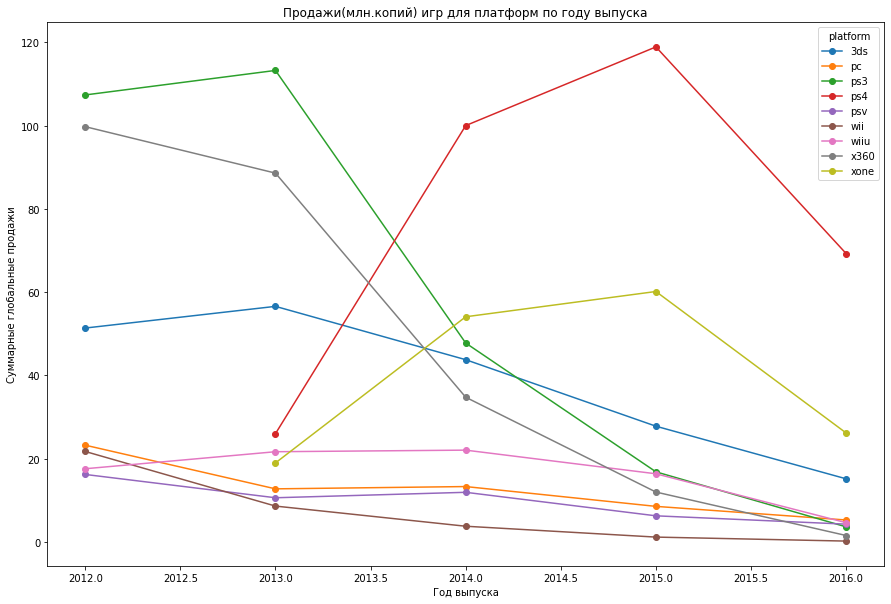

In [63]:
platform_info_actual.plot.line(figsize=(15,10), marker='o')
plt.xlabel(title_dict.get('year_of_release'))
plt.ylabel('Суммарные глобальные продажи')
plt.title('Продажи(млн.копий) игр для платформ по году выпуска');

**Выбор платформ**
- `pc` - в общем и целом продажи по ней небольшие, но стабильные в течении длительного времени, так же из-за особеностей развития индустрии и общей необходимости компьютера в жизни, у платформы будет свой рынок  (**потенциально прибыльная**)
- `ps3`, `x360` - на момент 2016 года платформы уже существуют 11 и 12 лет соответственно, при условии, что медианный жизненный цикл игр 11 лет для платформ с большим количеством продаж (**надо рассмотреть подробнее**)
- `3ds` - 6 лет на 2016 год, в 2017 году все еще можно ожидать продажи (**потенциально прибыльная**)
- `ps4`, `xone` - 4 года на момент 2016 года. У платформ прошлого поколения пик продаж был на 6 год. Т.к. в 2016 году наблюдается **общий** спад продаж по неясным причин (например, неполные данные за 2016 год, общие проблемы в индустрии), то не будем для этих платформ 2016 год считать тенденцией к общему снижению продаж и будем их считать перспективными на 2017 год. (**потенциально прибыльная**)
- `wii` - поддержка платформы была прекращена в 2013 году 
- `wiiu`, `psv` - 5 и 6 лет соответственно при жизненном цикле в 7 лет. Возможно, продажи будут, но уже совсем небольшие, тем более последние 3 года у платформ стабильный спад


**Итого** выбраны платформы `pc`, `ps4`, `xone`, `3ds`

### Общее количество продаж по платформам

Построим диаграммы размаха для платформ по глобальным продажам:
- по всем данным
- по выбранному периоду 2012-2016

Диаграммы размаха по всем данным помогут определить картину продаж по платформе за весь жизненный цикл и оценить ожидаемую картину по актуальным "схожим" платформам, например, PS3 и PS4, карманными платформами. <br>
Диаграмма размаха по 2012-2016 покажет актуальную картину по платформам, по которой можно будет оценить, как изменись продажи по платформам.

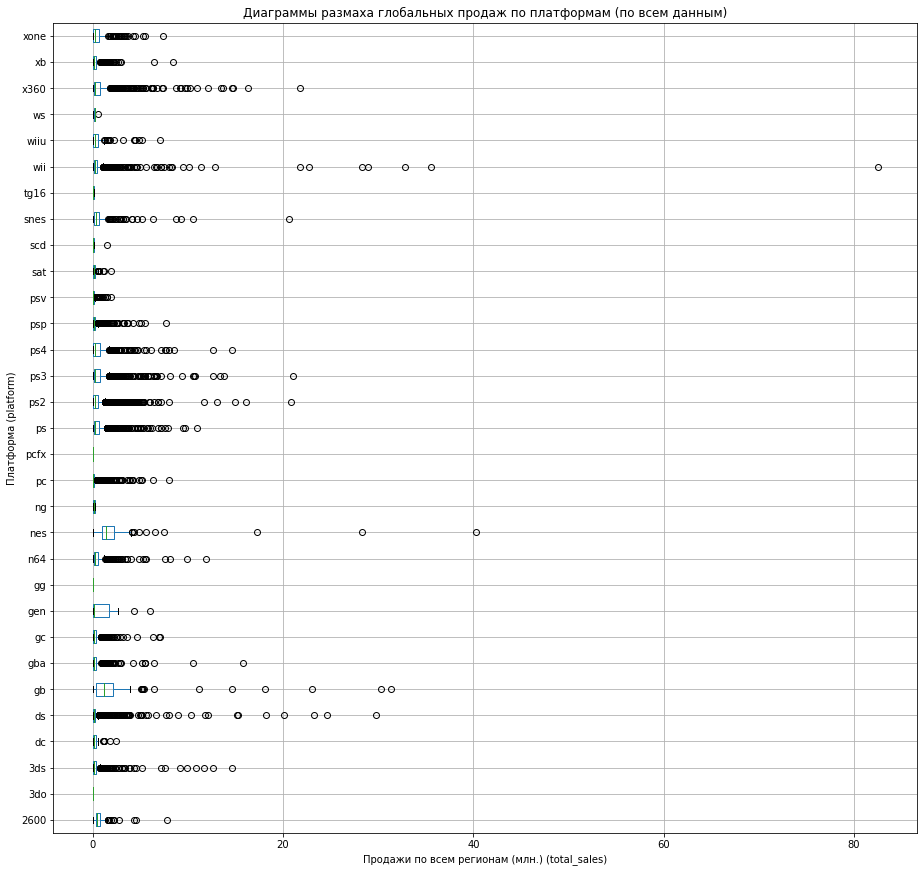

In [64]:
boxplotting('total_sales', 
            by_='platform', 
            titl='Диаграммы размаха глобальных продаж по платформам (по всем данным)')

Достаточно ярко выделяется `Wii Sports` - игра, которая поставлялась вместе с платформой.

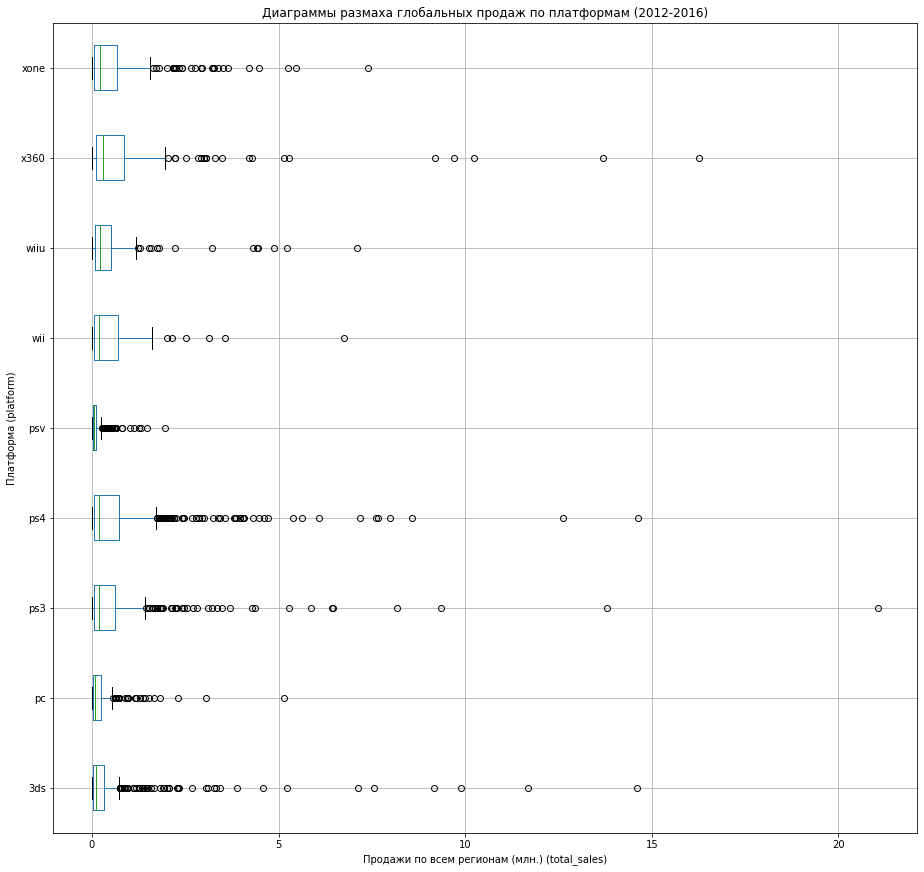

In [65]:
boxplotting('total_sales',  
            by_='platform', 
            data=df_games_actual,
            titl='Диаграммы размаха глобальных продаж по платформам (2012-2016)')

Укрупним результаты:

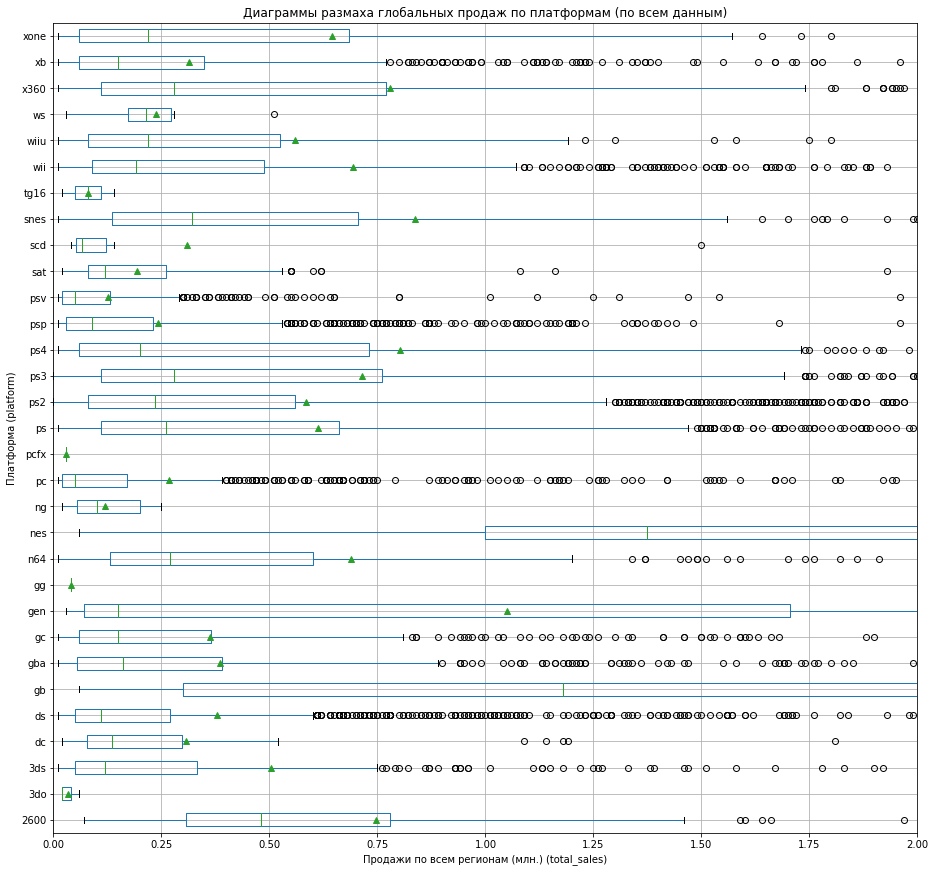

In [66]:
boxplotting('total_sales', 
            by_='platform', 
            titl='Диаграммы размаха глобальных продаж по платформам (по всем данным)', 
            lim=[0,2],
            showmeans=True)

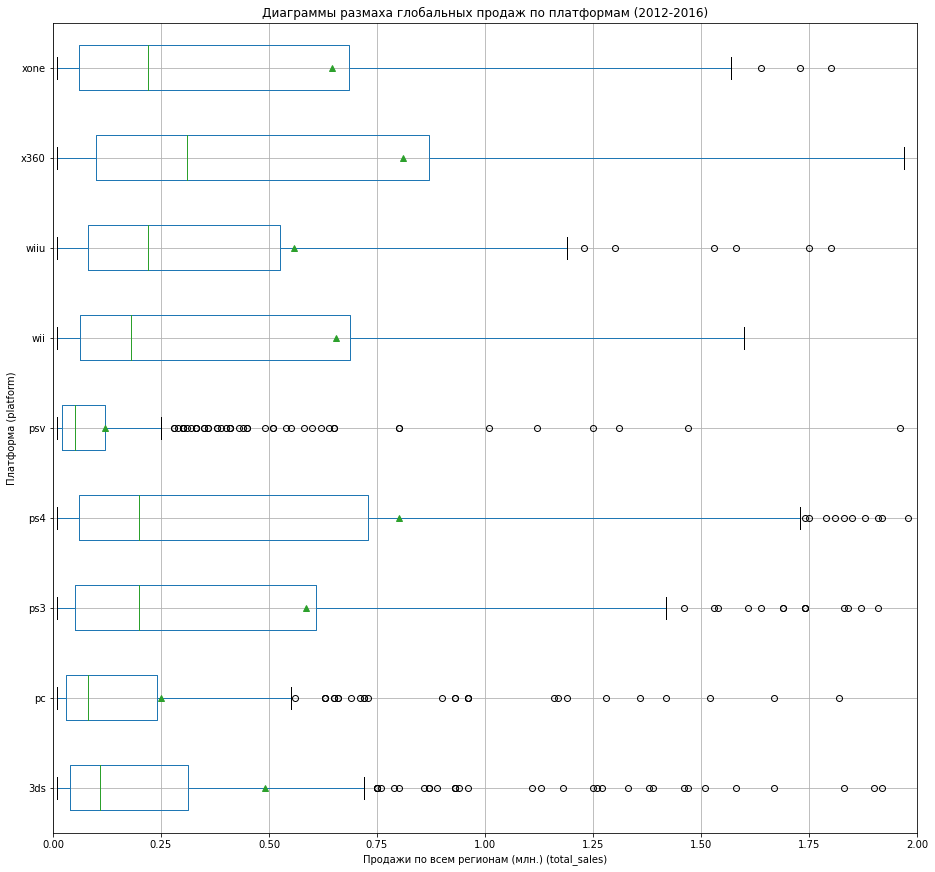

In [67]:
boxplotting('total_sales',  
            by_='platform',
            data=df_games_actual,
            titl='Диаграммы размаха глобальных продаж по платформам (2012-2016)',
            lim=[0,2], 
            showmeans=True)

На примере PS3: <br>
Можно отметить, что "тело" ящика уменьшилось: за весь период времени 50% продаж были от ~0.1 до ~0.75 с медианой в ~0.3 - за период 2012-2016 50% продаж приходятся на  ~0.05 - 0.6 с медианой в 0.2 <br>
"Ус" так же уменьшился, ~1.4 против 1.7. <br>
Подобная картина может означать, что платформа теряет свою популярность и становится менее привлекательной для пользователей. <br>
Так же можно отметить, что платформы прошлых поколений (PS, PS2, чей жизненный цикл завершился) показывают примерно одинаковое распределение, так что можно ожидать, что PS3 после окончания жизненного цикла так же придет к таким значениям. На 2017 год платформу еще можно рассматривать, как перспективную.

**Вывод (2012-2016)**
- для всех платформ 
    - медианное значение менее 0.25 млн.копий
    - среднее значение значительно удалено от медианного
    - есть игры, которые продавались значительно лучше, чем основная масса
- для выбранных платформ
    - для `xone` и `ps4` основная масса игр продается в количестве менее 2млн. копий
    - для `pc` и `3ds` основная масса менее 0.75млн. копий
- для сомнительных
    - у `x360` за период 2012-2016 год общие показатели (медиана, квартили) чуть лучше, чем общая картина. Это может означать, что платформа все еще интересна публике и ее тоже можно включить в список перспективных. 
    - так же по результатам выше можно включить `ps3`

In [68]:
platform_profit = ['pc','ps4','xone','3ds','ps3','x360']

### Зависимость оценок критиков и пользователей и продаж игры

Для удобства выделим нужные столбцы в отдельный датафрейм.

In [69]:
df_scores = df_games.query('platform in @platform_profit')[['platform',
                                                            'total_sales',
                                                            'user_score',
                                                            'critic_score']]

**Используемые функции**

In [70]:
def cheddock_scale(coeff: float) -> str:
    if coeff < 0.3:
        return 'Очень слабая'
    if coeff < 0.5:
        return 'Слабая'
    if coeff < 0.7:
        return 'Средняя'
    if coeff < 0.9:
        return 'Высокая'
    return 'Очень высокая'


def find_correlation(platform_name: str = '',
                     data: pd.DataFrame = df_scores,
                     target_name: str = 'total_sales',
                     ignore_outlier: bool = True) -> None:
    
    if platform_name:
        data = data.query('platform == @platform_name')
        print(f'Для платформы {platform_name}')
    
    if ignore_outlier:
        data = data.query('total_sales < total_sales.quantile(0.975)')
        
    depend = [x for x in data.columns if x != target_name and x != 'platform']
    
    for dep_name in depend:
        print(f'Зависимость между {target_name} и {dep_name}')
        data.plot(x=target_name, y=dep_name, kind='scatter', alpha=0.3)
        plt.show()
        coeff_corr = data[target_name].corr(data[dep_name])
        print(f'Коэффициент корреляции {coeff_corr:.2f}')
        print(f'{cheddock_scale(coeff_corr)} {"положительная" if coeff_corr > 0 else "отрицательная"} связь\n')
                     

Для оценки зависимости возьмем платформу `ps4`

Для платформы ps4
Зависимость между total_sales и user_score


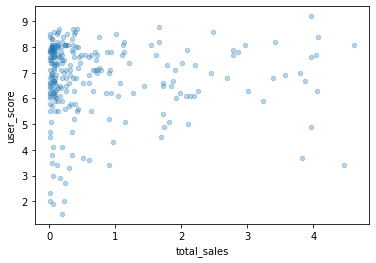

Коэффициент корреляции 0.01
Очень слабая положительная связь

Зависимость между total_sales и critic_score


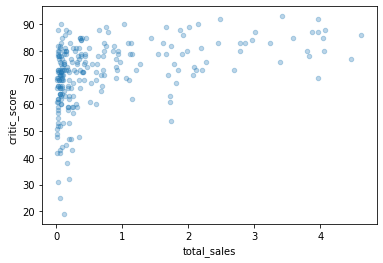

Коэффициент корреляции 0.40
Слабая положительная связь



In [71]:
find_correlation('ps4')

Можно сделать вывод, что оценки пользователей не влияют на продажи игры. <br>
Между оценками критиков и общими продажами наблюдается слабая положительная связь. Возможно, что есть влияние оценок критиков на продажи игры или данные факторы связаны между собой третьим фактором.


Проверим связь между оценками пользователей и критиков и общих продаж для остальных из выбранных платформ:

Для платформы x360
Зависимость между total_sales и user_score


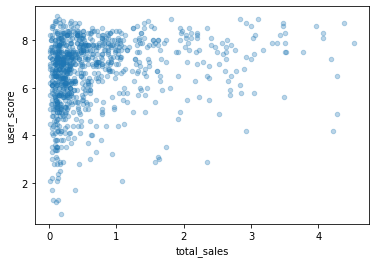

Коэффициент корреляции 0.21
Очень слабая положительная связь

Зависимость между total_sales и critic_score


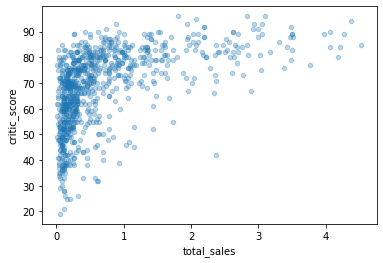

Коэффициент корреляции 0.51
Средняя положительная связь

Для платформы ps3
Зависимость между total_sales и user_score


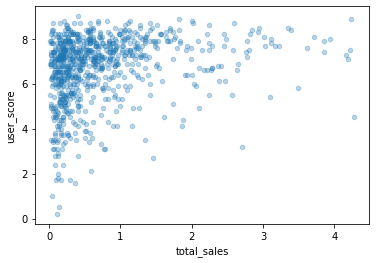

Коэффициент корреляции 0.24
Очень слабая положительная связь

Зависимость между total_sales и critic_score


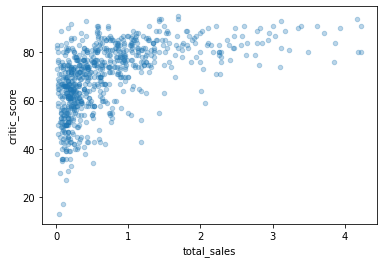

Коэффициент корреляции 0.52
Средняя положительная связь

Для платформы 3ds
Зависимость между total_sales и user_score


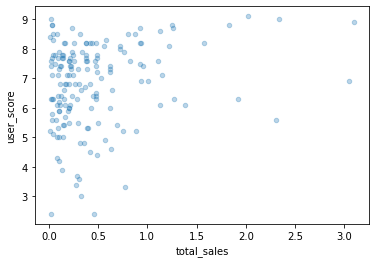

Коэффициент корреляции 0.21
Очень слабая положительная связь

Зависимость между total_sales и critic_score


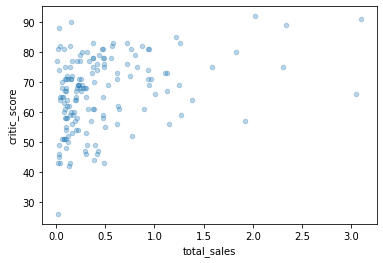

Коэффициент корреляции 0.33
Слабая положительная связь

Для платформы pc
Зависимость между total_sales и user_score


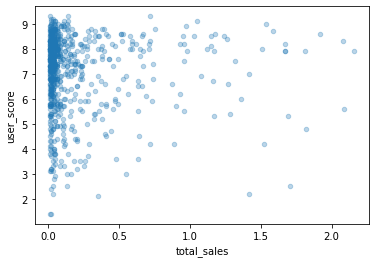

Коэффициент корреляции -0.02
Очень слабая отрицательная связь

Зависимость между total_sales и critic_score


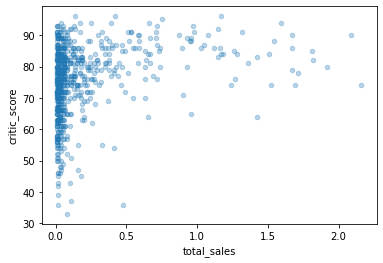

Коэффициент корреляции 0.27
Очень слабая положительная связь

Для платформы xone
Зависимость между total_sales и user_score


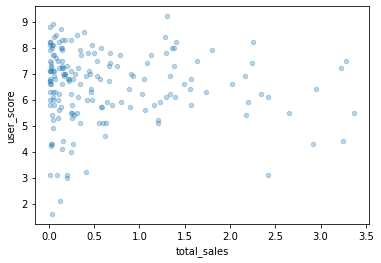

Коэффициент корреляции -0.05
Очень слабая отрицательная связь

Зависимость между total_sales и critic_score


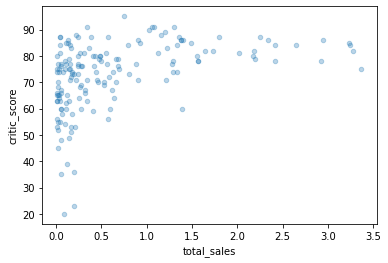

Коэффициент корреляции 0.42
Слабая положительная связь



In [72]:
for itm in df_scores['platform'].unique():
    if itm != 'ps4':
        find_correlation(itm)

Для остальных платформ наблюдается такая же картина.


Так же можно оценить эту зависимость для всех платформ за все время.

Зависимость между total_sales и user_score


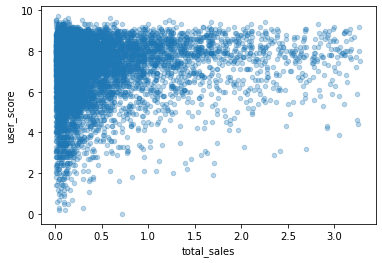

Коэффициент корреляции 0.13
Очень слабая положительная связь

Зависимость между total_sales и critic_score


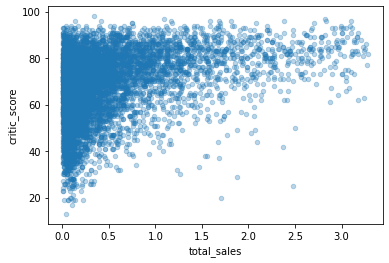

Коэффициент корреляции 0.34
Слабая положительная связь



In [73]:
find_correlation(data=df_games[['total_sales', 'user_score', 'critic_score']])

Для всех платформ за все время ситуация не изменилась.


**Вывод:** на общие продажи игры **не** влияют оценки пользователей, возможно **слабое** влияние оценок критиков.

### Влияние жанра игры на продажи

Влияние жанра будем рассматривать для выбранных актуальных данных:

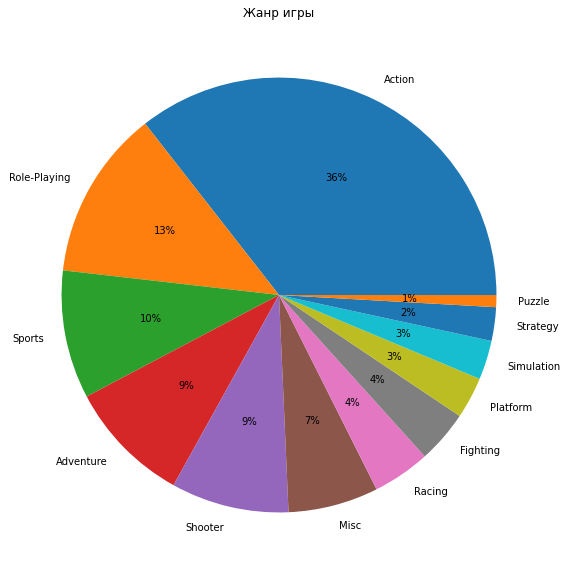

In [74]:
df_games_actual['genre'].value_counts().plot.pie(figsize=(10,10), 
                                                 title=title_dict['genre'],
                                                 ylabel='',
                                                 autopct='%1.f%%',);

Два наиболее популярных жанра `Action` и `Role-Playing` - почти половина от всех значений <br>
Наименее популярны `Puzzle` - 1%


Можно ожидать, что суммарные продажи по жанру будут примерно соответствовать популярности жанра

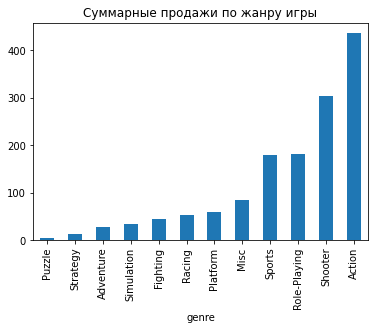

In [75]:
df_games_actual.groupby('genre')['total_sales'].sum() \
               .sort_values().plot.bar(title='Суммарные продажи по жанру игры');

Суммарные продажи примерно соответствуют популярности жанра, выражены 4 лидера. Второе место `Role-Playing` уступило жанру `Shooter`



Кроме суммарных продаж можно оценить медианные - в них нет особого влияния популярности жанра.

,total_sales
genre,
Adventure,0.04
Puzzle,0.06
Strategy,0.08
Simulation,0.12
Action,0.13
Racing,0.14
Misc,0.14
Fighting,0.15
Role-Playing,0.16


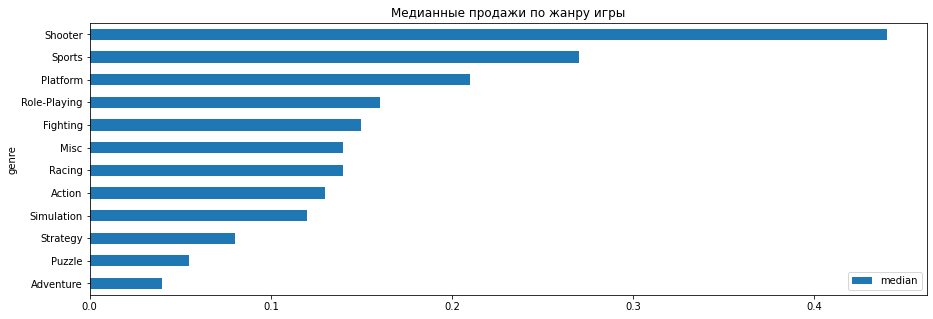

In [76]:
genre = df_games_actual.pivot_table(index='genre', 
                                    values='total_sales', 
                                    aggfunc='median').sort_values(by='total_sales')
genre.plot(kind='barh', title='Медианные продажи по жанру игры', figsize=(15,5))
plt.legend(['median']);
genre

В медианных продажах картина отличается от общих. <br>
Лидер суммарных продаж `Action` попал в нижнюю половину списка. С отрывом лидирует `Shooter`

**Вывод**<br>
Можно выделить два типа лидеров и аутсайдеров.
- по популярности `Action` и `Role-Playing` - игр этих жанров выпускается достаточно много и продается их так же много
- по медианным продажам `Shooter` и `Sports` - эти игры имеют чуть меньшую популярность, но зато каждая из игр, в основном, продается лучше
- `Puzzle` аутсайдер в обоих типах
- `Adventure` достаточно популярен (5 место 7%), но плохо продается

Построим диаграмму размаха глобальных продаж в разбивке по жанрам.

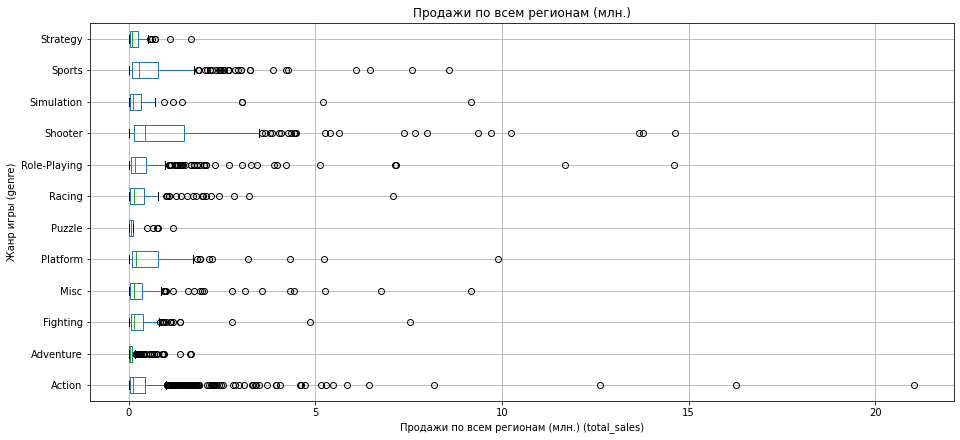

In [77]:
boxplotting('total_sales', by_='genre', data=df_games_actual, figsize_=(15,7))

Укрупним результат:

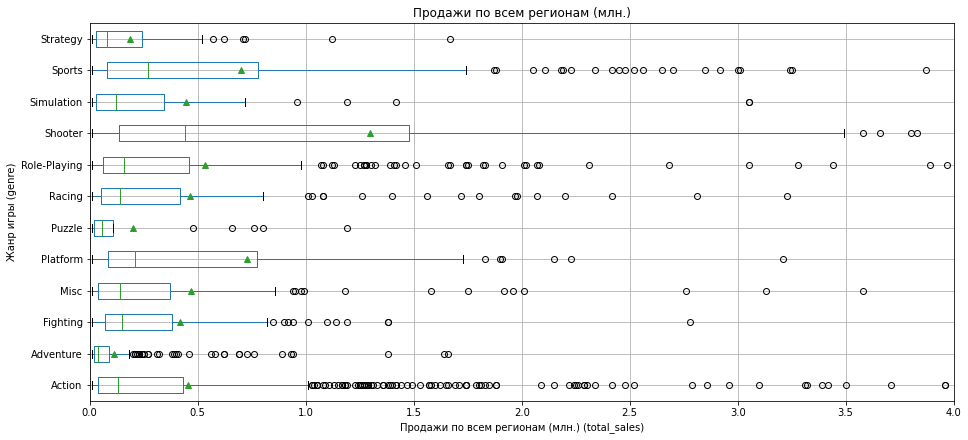

In [78]:
boxplotting('total_sales', by_='genre', data=df_games_actual, figsize_=(15,7), lim=[0,4], showmeans=True)

**Вывод:** <br>
диаграммы размаха подтверждают наш вывод о хороших продажах игр жанров `Shooter` и `Sports`. Так же можно отметить, что игры `Platform`, в целом, вполне могут конкурировать с `Sports` за второе место.


### Итог

- было изучено количество выпущенных игр по годам, для дальнейших исследований выбран период **2012-2016**
- было определено, что медианный срок жизни платформы **7** лет, для платформ с большими продажами медианный увеличивается до **11** лет с пиком продаж на примерно **5** год
- выбраны платформы  `pc`, `ps4`, `xone`, `3ds` как потенциально прибыльные
- изучено влияние оценок пользователей и критиков на продажи: влияния пользователей нет, влияние критиков слабое
- изучено влияние жанров игры на продажи, выделены лидеры `Action`, `Role-Playing`, `Shooter` и `Sports` 

## Портрет пользователей

**Используемые функции**

In [79]:
def top_5(data: pd.Series, name: str = '') -> pd.Series:
    data = data.sum().sort_values(ascending=False)
    data_sum = data.sum()
    data = data.head()
    data[f'Other {name}'] = data_sum - data.sum()
    return data

In [80]:
def user_portrait(name_column: str,
                  data_all: pd.DataFrame = df_games,
                  data: pd.DataFrame = df_games_actual,
                  targets: list = ['genre','platform'],
                  title_all: str = 'По всем данным',
                  title_curr: str = 'По выбранному периоду',
                  **kwargs) -> None:
    
    sum_all = data_all[name_column].sum()
    sum_cur = data[name_column].sum()
    for itm in targets:
        print(f'{title_dict.get(itm, itm)}({itm}):')
        
        itm_cur = top_5(data.groupby(itm)[name_column], itm)
        itm_all = top_5(data_all.groupby(itm)[name_column], itm)

        fig, ax = plt.subplots(ncols=2, figsize=(15,5))
        itm_all.plot(kind='pie', 
                     ax=ax[0], 
                     autopct='%1.f%%',
                     title=title_all, 
                     ylabel='',
                     **kwargs)
        itm_cur.plot(kind='pie',
                     ax=ax[1], 
                     autopct='%1.f%%',
                     title=title_curr,
                     ylabel='',
                     **kwargs)
        plt.show()
        itm_cur = itm_cur / sum_cur
        itm_all = itm_all / sum_all 
        diff = pd.concat([itm_all,itm_cur], axis=1)
        diff.columns = [title_all, title_curr]
        diff[diff.index != f'Other {itm}'].plot(kind='bar', figsize=(15,3), xlabel='', **kwargs)
        plt.title(f'Топ 5 от продаж по всем ({title_dict.get(itm,itm)})')
        plt.show()
        print();

In [81]:
countr_dict = {
    'eu_sales' : 'Для Европы',
    'na_sales' : 'Для Северной Америки',
    'jp_sales' : 'Для Японии'
}

  
def popular(target: str) -> None:
    fig, ax = plt.subplots(ncols=3, figsize=(15,3))
    for i, itm in enumerate(['eu_sales','na_sales','jp_sales']):
        data = top_5(df_games_actual.groupby(target)[itm], target)
        data.plot.pie(ax=ax[i], 
                      ylabel='',
                      autopct='%1.f%%',
                      title=countr_dict.get(itm, itm))

In [82]:
def results(target: str) -> None:
    print(countr_dict.get(target, target))
    explode_ = (0.12, 0.06, 0, 0, 0, 0)
    data = top_5(df_games_actual.groupby('platform')[target], 'platform')
    data.plot.pie(explode = explode_,
                  ylabel='',
                  autopct='%1.f%%',
                  title='Выбор платформы')

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    for i, itm in enumerate(data.index[0:2]):
        data_p = top_5(df_games_actual.query('platform == @itm').groupby('genre')[target], 'genre')
        data_p.plot.pie(explode = explode_,
                        ax=ax[i][0],
                        ylabel='',
                        autopct='%1.f%%',
                        title=f'Выбор жанра для платформы {itm}')
        for j, j_itm in enumerate(data_p.index[0:2]):
            top_5(df_games_actual.query('platform == @itm and genre == @j_itm')
                                 .groupby('rating')[target], 'rating').plot.pie(ax=ax[i][j+1],
                                                                                ylabel='',
                                                                                autopct='%1.f%%',
                                                                                title=f'Выбор рейтинга для жанра {j_itm} \n платформы {itm}')

### Регион EU

Жанр игры(genre):


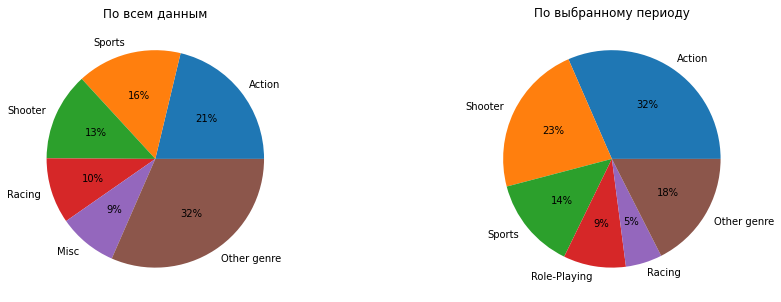

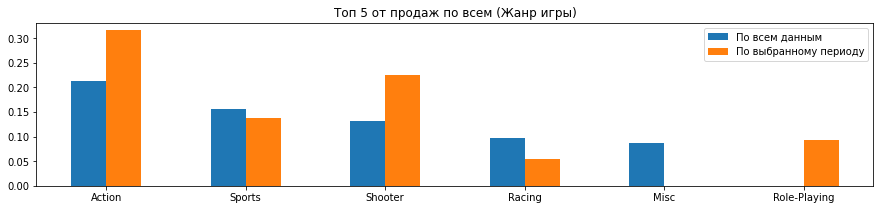


Платформа(platform):


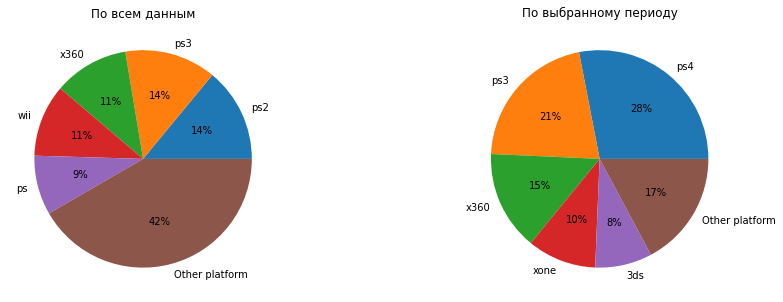

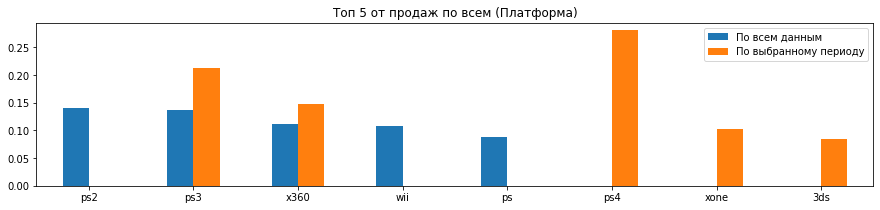

In [83]:
user_portrait('eu_sales', rot=0)

На круговой диаграмме отображено соотношение топ5 жанров/платформ по отношению друг к другу. На гистограмме по отношению к продажам по всем жанрам и платформам.


Можно оценить, что в `EU` последнее время растет популярность `Action` и `Shooter`. Так же в последнее время стал популярен жанр `Role-Playing`.  <br>
Так же в последнее время наиболее популярные жанры захватывают бОльшую часть рынка - 2 лидера занимают около 50% от рынка для актуального времени против примерно 37% для всего времени.



В последнее время наибольшую популярность получила платформа `ps4`. Так же в лидерах остаются наиболее популярные за все время `ps3` и `x360`. Так же можно заметить "ротацию" платформ - устаревшие уходят, новые набирают популярность.


Усредненный игрок региона `EU` будет играть на консоли PlayStation 3-4 в игры `Action` и `Shooter`

### Регион NA

Жанр игры(genre):


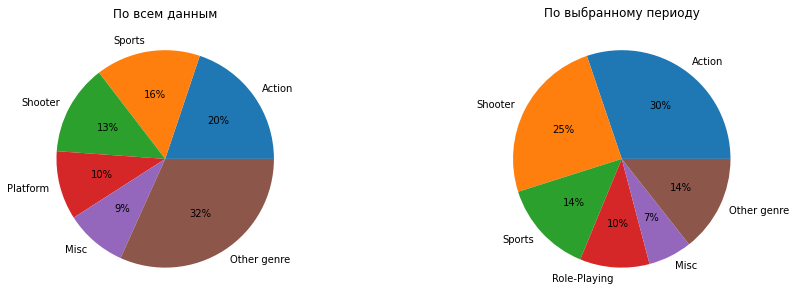

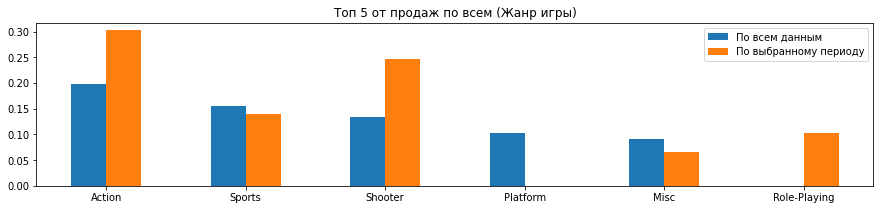


Платформа(platform):


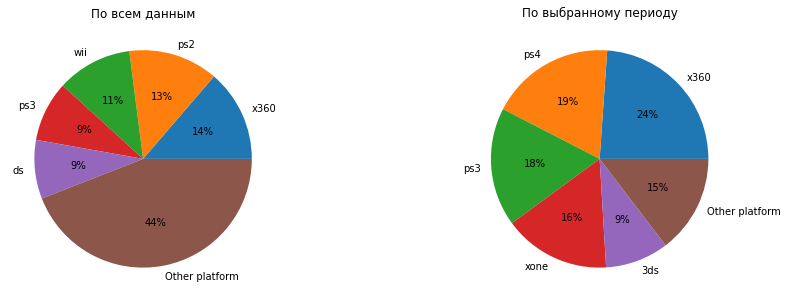

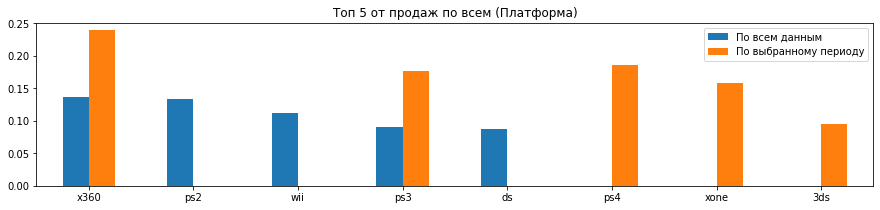

In [84]:
user_portrait('na_sales', rot=0)

По жанрам в регионе `NA` наблюдается практически та же картина, что и в регионе `EU`, за исключением популярности гонок `Racing` и аркадных `Misc` игр.


А вот предпочитаемые платформы различаются - в силу особенностей и сервиса в регионе `NA` консоли типа `xbox` популярны больше, чем в `EU` и занимают лидирующую позицию.


Усредненный игрок региона `NA` будет играть на консоли Xbox360 и PlayStation4 в игры `Action` и `Shooter`

### Регион JP

Жанр игры(genre):


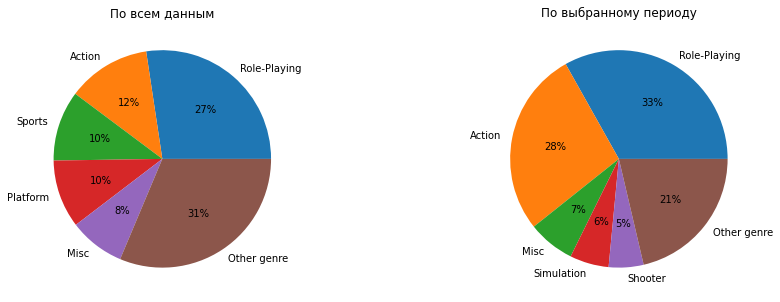

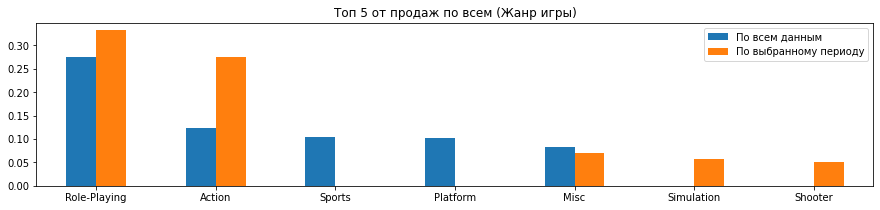


Платформа(platform):


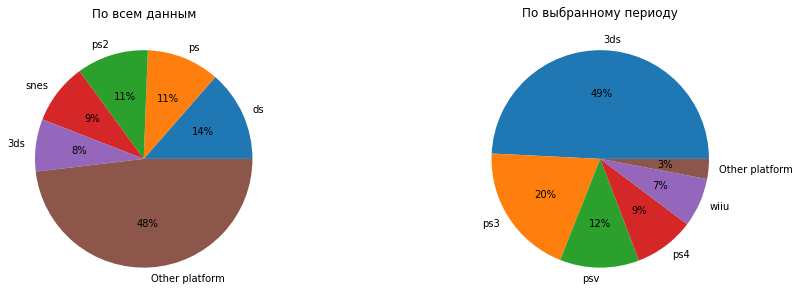

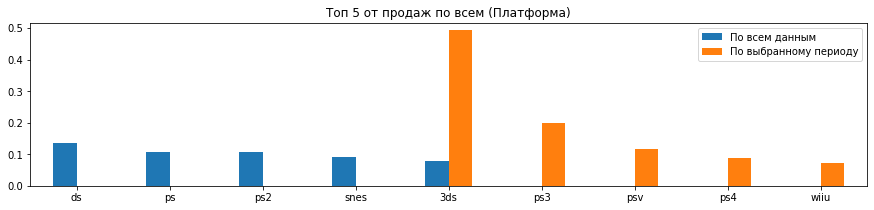

In [85]:
user_portrait('jp_sales', rot=0)

Картина для игрока региона `JP` значительно отличается от игроков `EU` и `NA`.


Игроки в Японии предпочитают РПГ `Role-Playing` игры, в последнее время популярность завоевывает `Action`.


По всем данным нет наиболее популярной платформы, продажи по всем практически одинаковы. Но в последнее время огромную популярность(50% рынка) получила платформа `3ds`. Так же можно отметить, что Xbox любого поколения не попало в топ, Японские игроки предпочитают PlayStation.


Усредненный игрок региона `JP` будет играть на Nintendo 3DS в игры `Role-Playing` и `Action`

### Влияние рейтинга ESRB

Для удобства заполним пропущенные значения 

In [86]:
df_games_actual['rating'] = df_games_actual['rating'].fillna('None')

Посмотрим распределение игр для каждого из регионов.

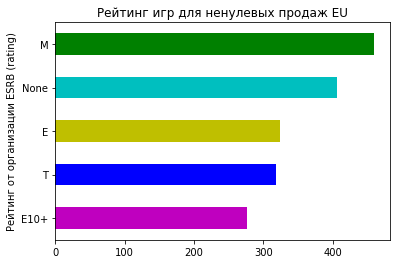

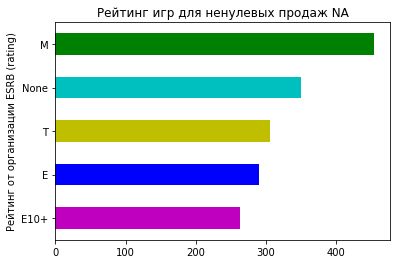

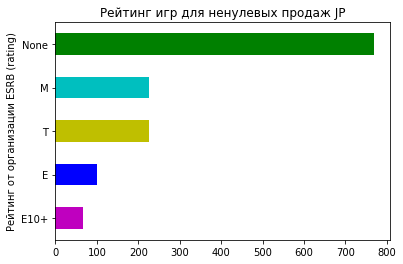

In [87]:
base_check(df_games_actual.query('eu_sales > 0'), 'rating', set_title = 'Рейтинг игр для ненулевых продаж EU')
base_check(df_games_actual.query('na_sales > 0'), 'rating', set_title = 'Рейтинг игр для ненулевых продаж NA')
base_check(df_games_actual.query('jp_sales > 0'), 'rating', set_title = 'Рейтинг игр для ненулевых продаж JP')

Для каждого региона построим гистограммы по средним и медианным продажам в зависимости от рейтинга и "ящики с усами". "Нулевые" продажи так же не будем учитывать.


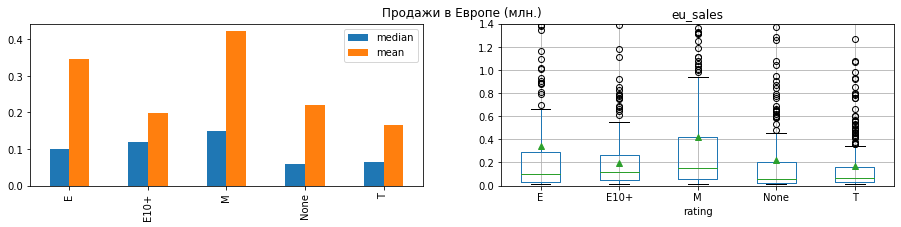

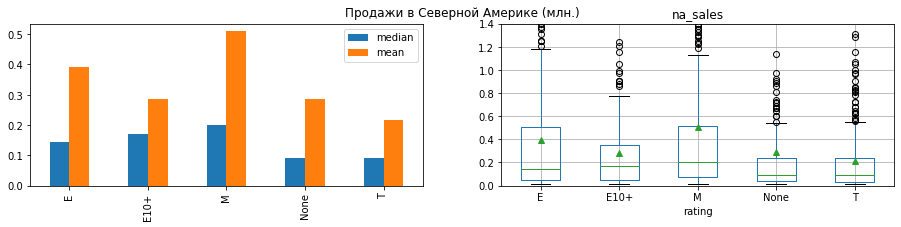

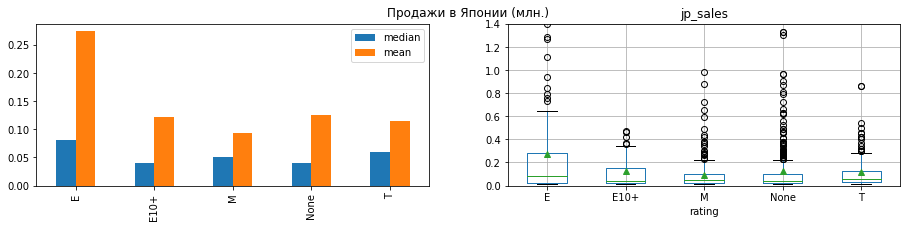

In [88]:
for itm in ['eu_sales','na_sales','jp_sales']:
    fig, ax = plt.subplots(ncols=2, figsize=(15,3))
    ax_0 = df_games_actual[df_games_actual[itm] > 0].pivot_table(index='rating',
                                                                 values=itm,
                                                                 aggfunc=['median','mean'])
    
    ax_0.columns = ['median','mean']
    ax_0.plot.bar(ax=ax[0], xlabel='', title='')
    df_games_actual[df_games_actual[itm] > 0].boxplot(ax=ax[1], 
                                                      column=itm, 
                                                      by='rating', 
                                                      showmeans=True)
    fig.suptitle(title_dict.get(itm,itm))
    plt.ylim([0,1.4])
    

И оценим суммарные продажи по каждой из категорий.

In [89]:
rating = df_games_actual.pivot_table(index='rating', values=['eu_sales','na_sales','jp_sales'], aggfunc='sum')
rating = rating / rating.sum()
rating.style.format('{:.1%}') \
      .highlight_max(color='lightblue') \
      .highlight_min(color='pink')

,eu_sales,jp_sales,na_sales
rating,,,
E,22.2%,15.5%,19.3%
E10+,10.9%,4.6%,12.8%
M,38.6%,11.9%,39.5%
None,17.8%,53.6%,17.1%
T,10.5%,14.4%,11.3%


Можно сделать вывод, что рейтинг влияет на продажи в разных регионах.


Для `EU` и `NA` картина схожа, игроки предпочитают игры категории `M` - игры для аудитории 17+, как медианным значениям, так и по суммарным.


Для `JP` сущесвует очень много игр без рейтинга и по ним ожидаемо много суммарных продаж, но самые низкие медианные продажи. По медианным продажам лидируют игры категории `E` - для всех.

### Итог

- были изучены "портреты пользователей" в трех регионах `EU`, `NA` и `JP`
    - Усредненный игрок региона `EU` будет играть на консоли PlayStation 3-4 в игры `Action` и `Shooter`
    - Усредненный игрок региона `NA` будет играть на консоли Xbox360 и PlayStation4 в игры `Action` и `Shooter`
    - Усредненный игрок региона `JP` будет играть на Nintendo 3DS в игры `Role-Playing` и `Action`
- было изучено влияние рейтинга ESRB на продажи игр. для регионов `EU` и `NA` пользователи предпочитают игры с рейтингом `M` -  для взрослых. в регионе `JP` это категория `E` - для всех.

## Проверка гипотез


**Используемые функции:**

In [90]:
def t_test(first, 
           second,
           name_first: str = 'first',
           name_second: str = 'second',
           titl: str = 'Плотность вероятностей',
           alpha: float = .05,
           equal_vars: bool = False) -> None:
    
    sns.kdeplot(first, shade=True)
    sns.kdeplot(second, shade=True)
    plt.legend([name_first, name_second])
    plt.title(titl);
    plt.show()
    
    p_val = stats.ttest_ind(first, second, equal_var = equal_vars).pvalue
    
    print(f'P-value = {p_val}')
    print(f'При alpha = {alpha} {"отвергаем" if alpha > p_val else "не получилось отвергнуть"} нулевую гипотезу')

Статистическая практика показывает, что в общем случае (когда нет заведомо равных популяционных дисперсий) лучше использовать тест Уэлча. Для исследования будем использовать именно его.

Уровень значимости alpha примем равным 5% (`alpha=0.05`).

### Пользовательские рейтинги платформ Xbox One и PC

Платформа Xbox One появилась недавно и в рассматриваемый момент времени "пик" развития не пройден. PC существует давно и в момент появления Xbox уже на спаде, "пик" пройден. Можно предположить, что средние оценки для игры в зависимости от выбранного периода жизненного цикла игры могут различаться  <br>


Рассмотрим гипотезу для двух вариантов
- для всех данных
- для выбранного периода 2012-2016


Сформулируем нулевую и альтернативную гипотезы: <br>
**Нулевая** H0: Средние пользовательские рейтинги платформ Xbox One и PC равны <br>
**Альтернативная** H1: Средние пользовательские рейтинги платформ Xbox One и PC не равны

**Для всех данных**

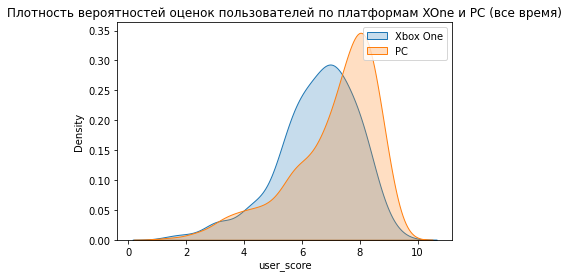

P-value = 4.20093729348826e-06
При alpha = 0.05 отвергаем нулевую гипотезу


In [91]:
t_test(df_games.query('platform == "xone"')['user_score'].dropna(),
       df_games.query('platform == "pc"')['user_score'].dropna(), 
       name_first = 'Xbox One', 
       name_second = 'PC', 
       titl='Плотность вероятностей оценок пользователей по платформам XOne и PC (все время)')

**Вывод:** Альтернативная гипотеза, средние пользовательские рейтинги платформ Xbox One и PC **не** равны

**Для выбранного периода 2012-2016**

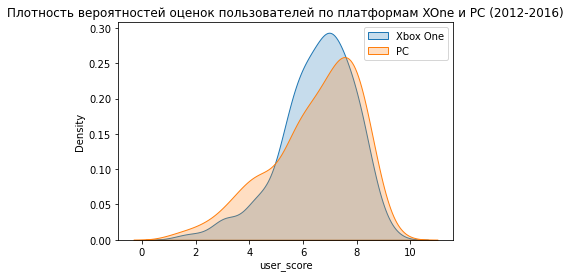

P-value = 0.5926118514134859
При alpha = 0.05 не получилось отвергнуть нулевую гипотезу


In [92]:
t_test(df_games_actual.query('platform == "xone"')['user_score'].dropna(),
       df_games_actual.query('platform == "pc"')['user_score'].dropna(), 
       name_first = 'Xbox One', 
       name_second = 'PC', 
       titl='Плотность вероятностей оценок пользователей по платформам XOne и PC (2012-2016)')

**Вывод:** Нулевая гипотеза, средние пользовательские рейтинги платформ Xbox One и PC равны

### Пользовательские рейтинги жанров Action и Sports 

В ходе исследования было оценено, что игры жанра `Action` набрали популярность к актуальному времени, что может влиять и на средние оценки в зависимости от периода. Так же сделаем  проверку гипотезы по 2 временным периодам.


Сформулируем нулевую и альтернативную гипотезы: <br>
**Нулевая** H0: Средние пользовательские рейтинги для игр жанров `Action` и `Sports` равны <br>
**Альтернативная** H1: Средние пользовательские рейтинги для игр жанров `Action` и `Sports` не равны

**Для всех данных**

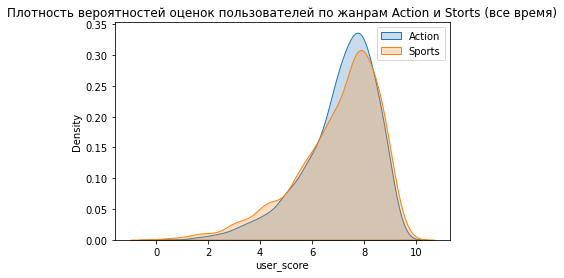

P-value = 0.09455979262895202
При alpha = 0.05 не получилось отвергнуть нулевую гипотезу


In [93]:
t_test(df_games.query('genre == "Action"')['user_score'].dropna(),
       df_games.query('genre == "Sports"')['user_score'].dropna(), 
       name_first = 'Action', 
       name_second = 'Sports', 
       titl='Плотность вероятностей оценок пользователей по жанрам Action и Storts (все время)')

**Вывод:** Нулевая гипотеза, средние пользовательские рейтинги для игр жанров `Action` и `Sports` равны

**Для выбранного периода 2012-2016**

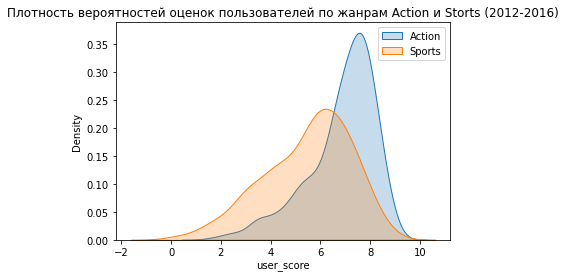

P-value = 4.3225831682773337e-20
При alpha = 0.05 отвергаем нулевую гипотезу


In [94]:
t_test(df_games_actual.query('genre == "Action"')['user_score'].dropna(),
       df_games_actual.query('genre == "Sports"')['user_score'].dropna(), 
       name_first = 'Action', 
       name_second = 'Sports', 
       titl='Плотность вероятностей оценок пользователей по жанрам Action и Storts (2012-2016)')

**Вывод:** Альтернативная гипотеза, средние пользовательские рейтинги для игр жанров `Action` и `Sports` **не** равны

## Вывод

Основной целью исследования было опредение факторов, влияющих на успешность игры.


Для этого сначала был выбран временной период, данные за которые актуальны для исследования продаж в средующем году. Было предположено, что игровая индустрия c 2012 года и по 2016 находится в достаточно стабильном состоянии и в 2017 можно ожидать сохранение тенденции. <br>
Так же для выбора периода прогнозирования можно учитывать, что на данном этапе развития индустрии игры разрабатываются достаточно долго, так игры ААА-класса разрабатываются, в среднем, 2.5 года. Многие из них дают анонсы сильно заранее, что может повлиять на интерес к жанру и популярности платформы в целом, а не только для конкретной игры. <br>
Соответственно, для прогнозирования можно взять период 3-5 лет, т.к. можно отследить не просто интерес к играм за последний год, но и тенденции для жанров, платформ и т.п.

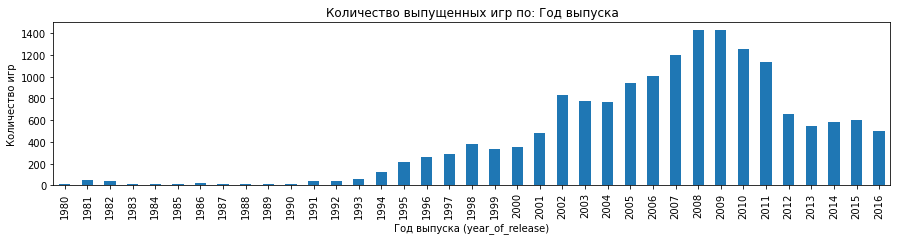

In [95]:
base_check(df_games,'year_of_release', is_bar=True, figsize=(15,3), show_info=False)

Далее было определено, что средний срок жизни платформы **7 лет** для всех платформ и **11** лет с "пиком" на уровне **5** лет для наиболее популярных платформ (платформ с большими продажами). Для выбора перспективных платформ были отобраны платформы, которые на момент 2016 года сохранили продажи.

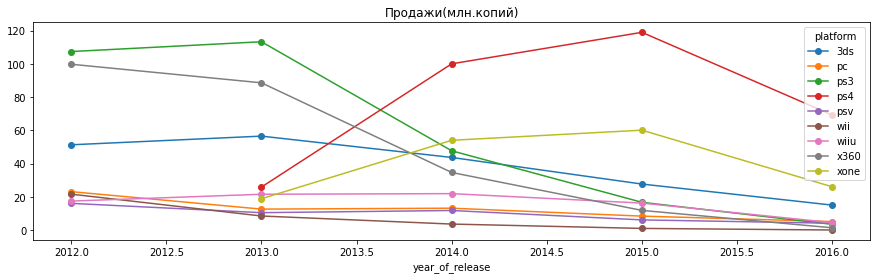

In [96]:
platform_info_actual.plot.line(figsize=(15,4), marker='o', title='Продажи(млн.копий)');

Было изучено, на каком этапе жизненного цикла каждая из платформ будет находиться в 2017 году и отобраны платформы `pc`, `ps4`, `xone`, `3ds` как перспективные на 2017.

Было оценено вляние оценок критиков и пользователей на продажи по регионам и по всем продажам. Во всех случаях влияния оценок пользователей обнаружено не было, влияние оценок критиков слабое.

Было изучено влияние жанра игры на продажи и выделено два типа лидеров
- по общей популярности и продажам - жанр `Action`
- по медианным продажам - жанр `Shooter`

Для оценки продаж в разных регионах был составлен портрет пользователей для каждого из регионов. <br>


**По жанрам**

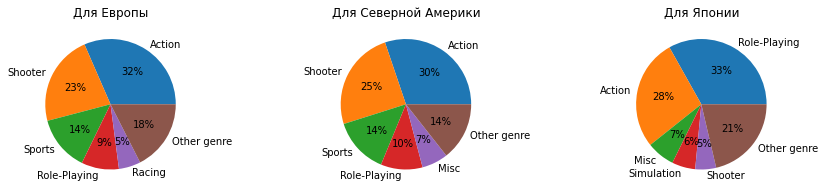

In [97]:
popular('genre')

Было выявлено, что игроки в Европе и Америке предпочитают игры жанров `Action` и `Shooter`, а японские игроки `Role-Playing` и `Action`. Значит, в зависимости от региона продажи имеет смысл обращать внимание на разные жанры игры.


**По платформам**

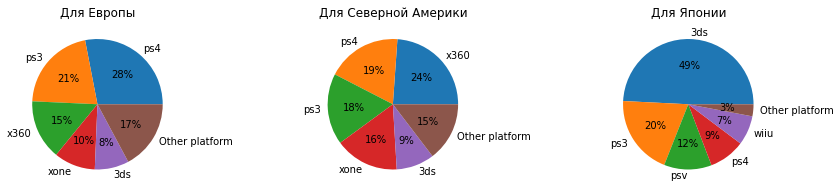

In [98]:
popular('platform')

Было выявлено, что в Европе игроки отдают предпочтение PlayStation, в Америке Хbox и PlayStation любят примерно одинаково. В Японии  яркий лидер Nintendo DS, отстает PlayStation, а вот Xbox в лидеры вообще не попало.


**По рейтингу**

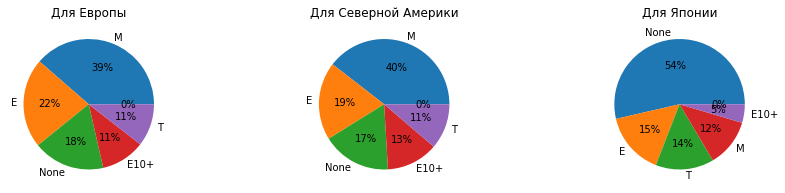

In [99]:
popular('rating')

В Европе и Америке предпочитают игры с рейтингом `M` - старше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории. <br>
Игроки Японии предпочитают игры категорий `E` - для всех и `T` - для подростков, старше 13 лет.

Были проверены гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

каждая из которых показала разный результат в зависимости от выбранного периода.

**Рекомендации:** <br>
Общие для всех регионов: 
- оценка пользователей не влияет на продажи игры, ее можно не учитывать
- оценка критиков на продажи влияет слабо

Для Европы


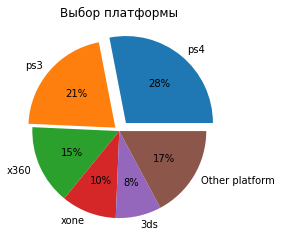

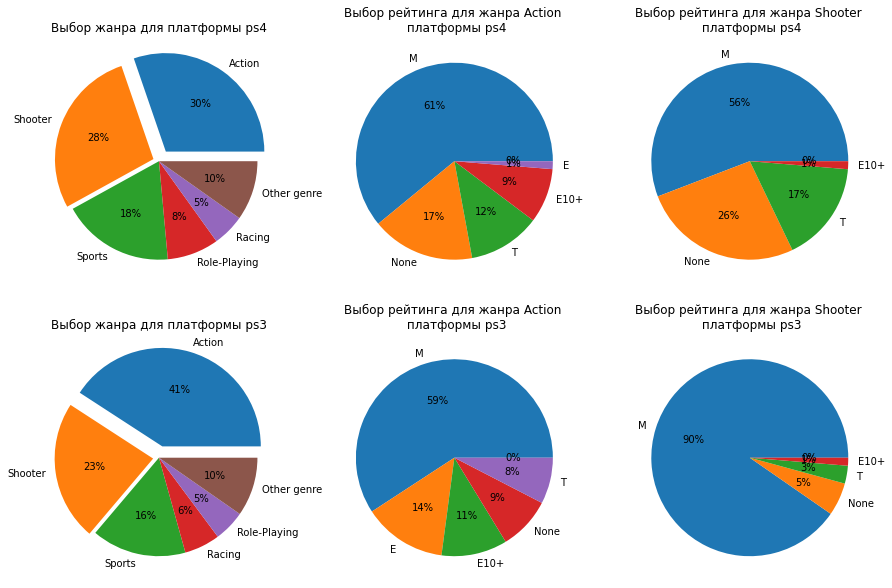

In [100]:
results('eu_sales')

Для региона EU, в порядке приоритета:
- платформа PS4
    - игры жанра `Action` c рейтингом `M` (для взрослых)
    - игры жанра `Shooter` с рейтингом `M` (для взрослых)
- платформа PS3
    - игры жанра `Action` c рейтингом `M` (для взрослых)
    - игры жанра `Shooter` с рейтингом `M` (для взрослых)

Для Северной Америки


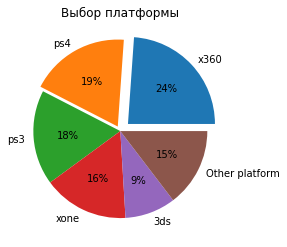

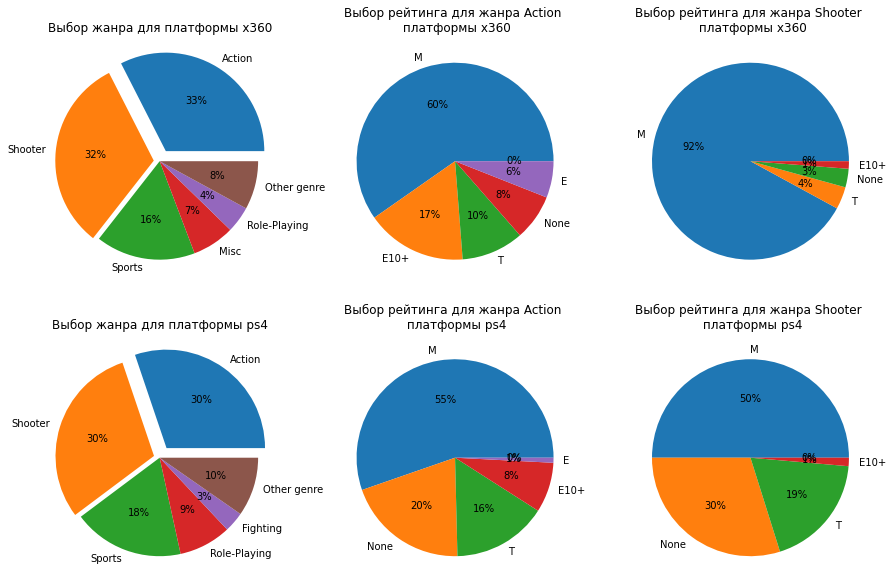

In [101]:
results('na_sales')

Для региона NA, в порядке приоритета:
- платформа x360
    - игры жанра `Action` c рейтингом `M` (для взрослых)
    - игры жанра `Shooter` с рейтингом `M` (для взрослых)
- платформа PS4
    - игры жанра `Action` c рейтингом `M` (для взрослых)
    - игры жанра `Shooter` с рейтингом `M` (для взрослых)

Для Японии


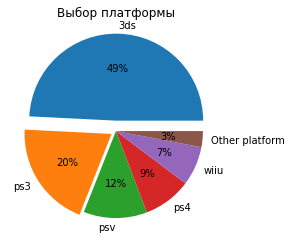

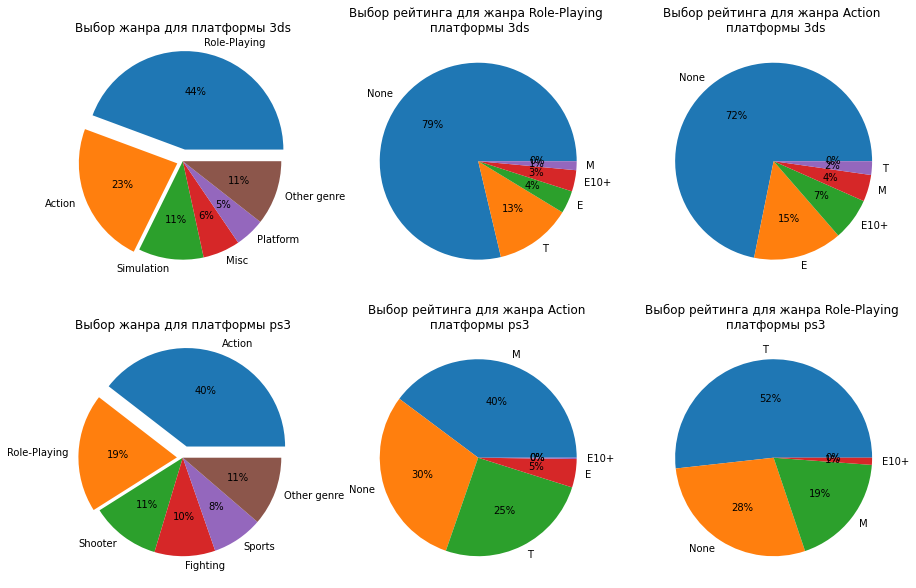

In [102]:
results('jp_sales')

Для региона JP, в порядке приоритета:
- платформа 3ds (половина рынка)
    - игры жанра `Role-Playing` без учета рейтинга ESRB
    - игры жанра `Action` без учета рейтинга ESRB
- платформа PS3
    - игры жанра `Action` c рейтингом `M` (для взрослых)
    - игры жанра `Role-Playing` с рейтингом `T` (для подростков)